# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

## Annalisa Paladino

Advanced Topics in Machine Learning -- Fall 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

## Assignment

### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.


And please, avoid doing that... 👇🏻

![image.png](attachment:image.png)

## Solution

### Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_classification
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Section 1: Understanding data geometry

Load the dataset [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist) in the most suitable form for the tasks that follow.

Remember to consider the *dataset* as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

The images from the dataset are 784-dimensional images.

The dataset contains 60k training examples, and 10k testing examples. Each training example is accomanied with a respective label, which can either be:

- 0: T-shirt/top

- 1: Trouser

- 2: Pullover

- 3: Dress

- 4: Coat

- 5: Sandal

- 6: Shirt

- 7: Sneaker

- 8: Bag

- 9: Ankle boot

In [38]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = trainset.data.numpy().reshape(trainset.data.shape[0], -1)
y_train = trainset.targets.numpy()
X_test = testset.data.numpy().reshape(testset.data.shape[0], -1)
y_test = testset.targets.numpy()

df_train = pd.DataFrame(X_train)
df_train['label'] = y_train
df_test = pd.DataFrame(X_test)
df_test['label'] = y_test

# Downsample the data
df_train, _ = train_test_split(df_train, test_size=0.9, stratify=df_train['label'])

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train.iloc[:, :-1])
y_train = df_train['label'].values
X_test = scaler.transform(df_test.iloc[:, :-1])
y_test = df_test['label'].values

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

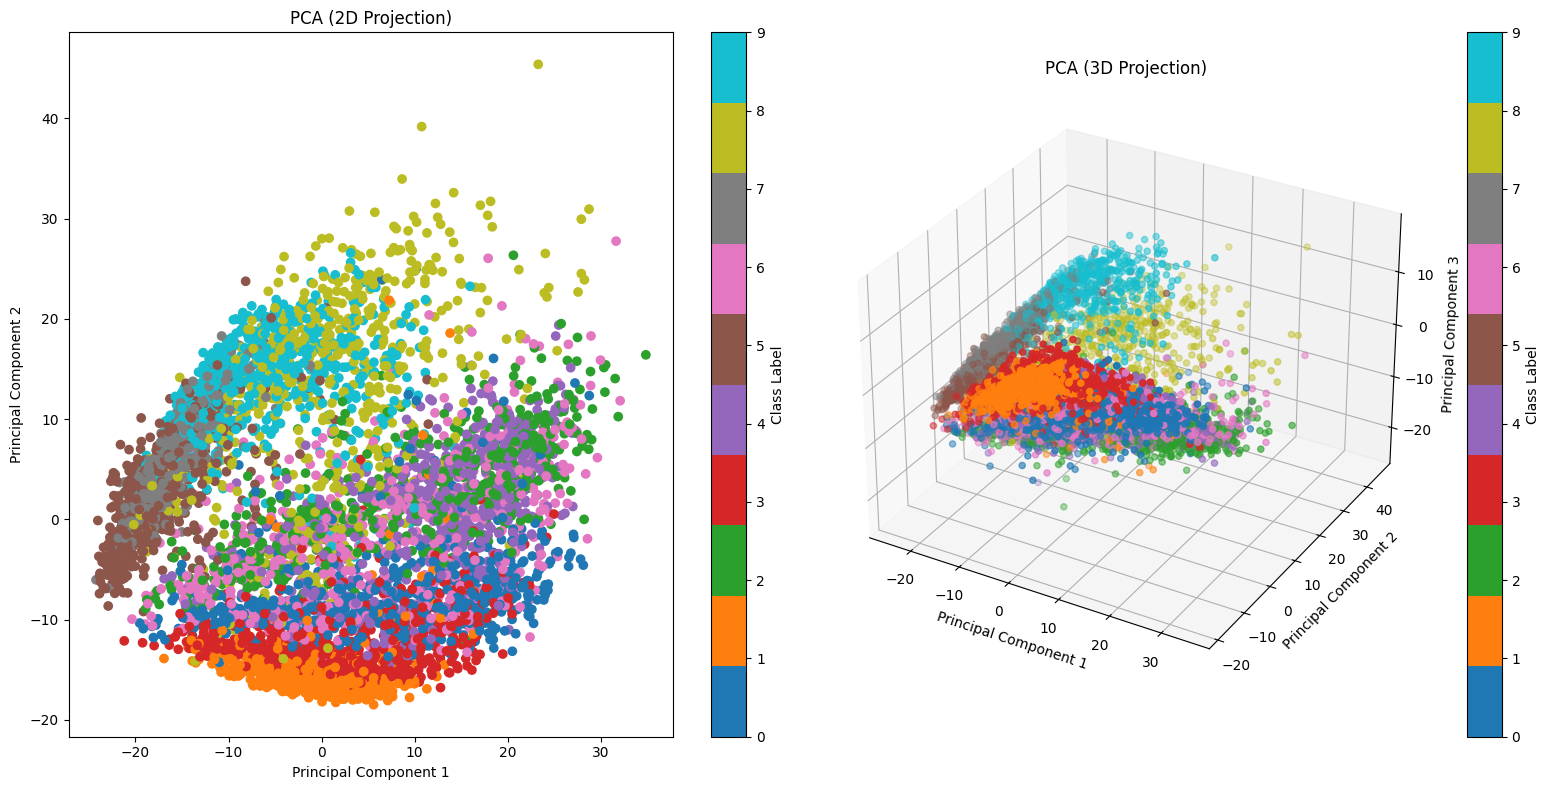

In [39]:
# PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_train)

fig = plt.figure(figsize=(16, 8))

# 2D Plot: First two components
ax1 = fig.add_subplot(121)
scatter = ax1.scatter(principal_components[:, 0], principal_components[:, 1], c=y_train, cmap='tab10')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA (2D Projection)')
plt.colorbar(scatter, ax=ax1, label='Class Label')

# 3D Plot: First three components
ax2 = fig.add_subplot(122, projection='3d')
sc = ax2.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
                 c=y_train, cmap='tab10', depthshade=True)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('PCA (3D Projection)')
fig.colorbar(sc, ax=ax2, label='Class Label')

plt.tight_layout()
plt.show()

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

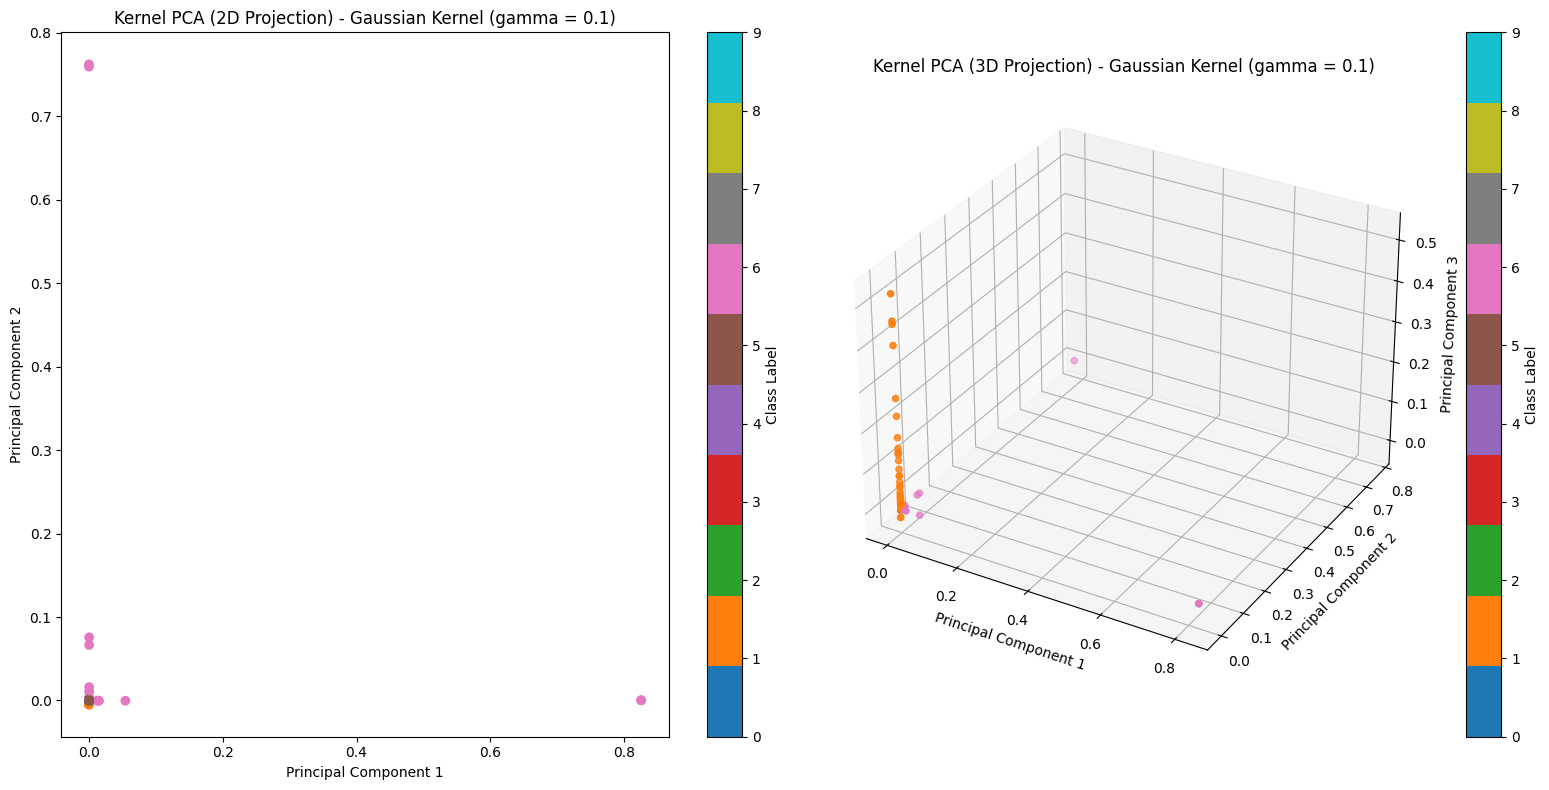

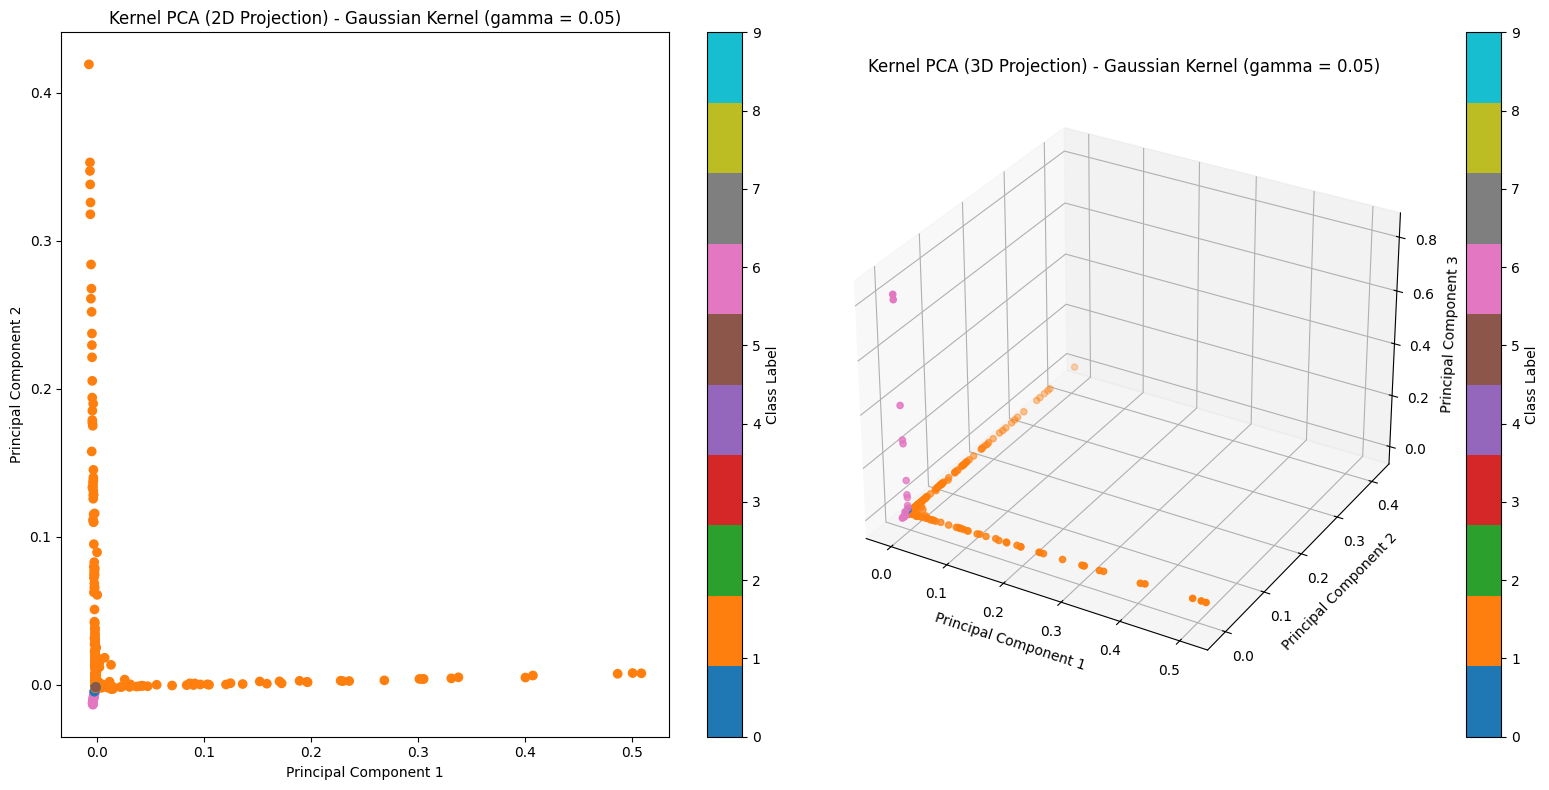

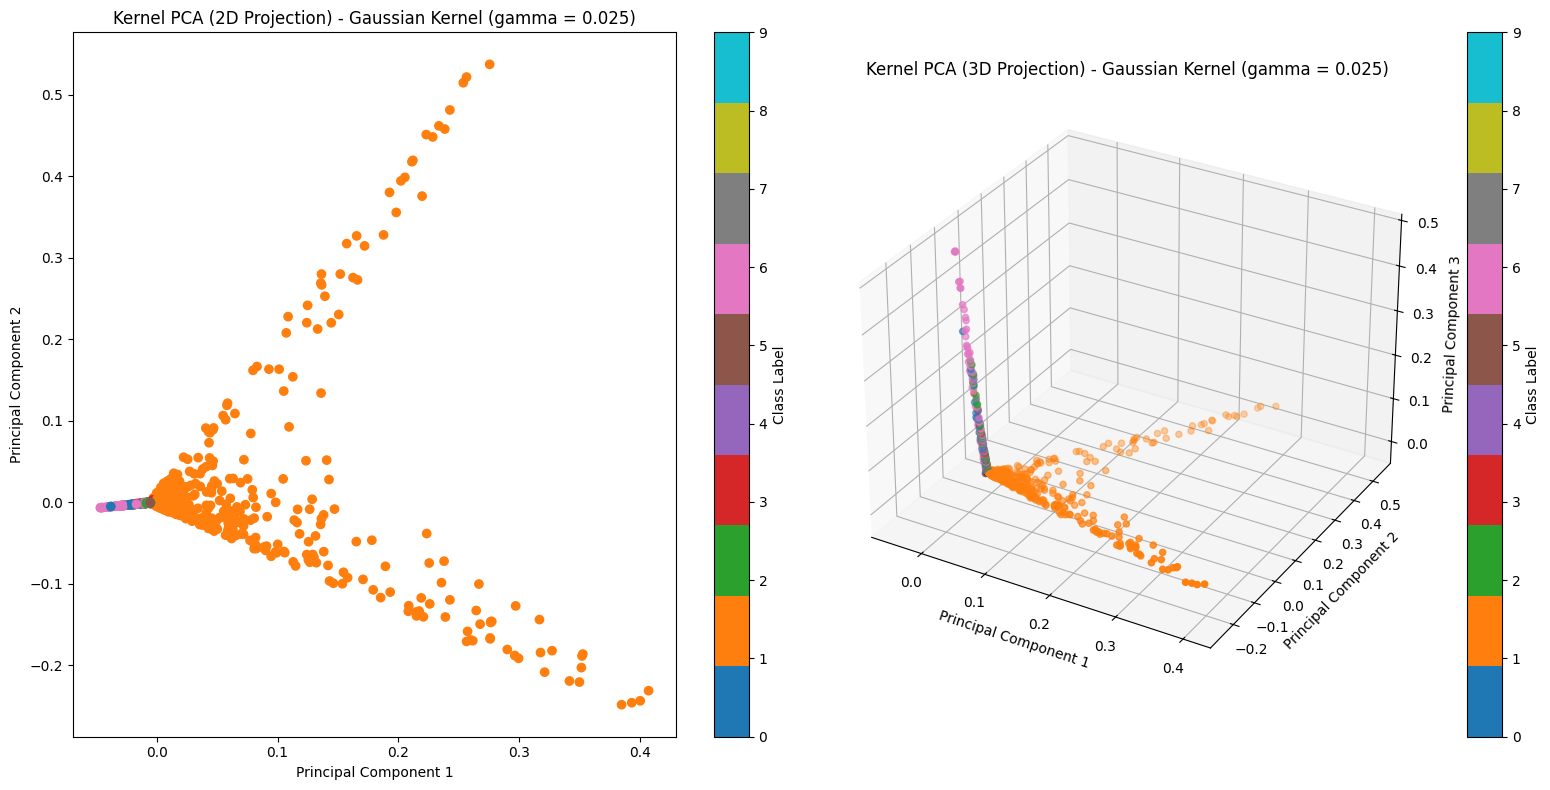

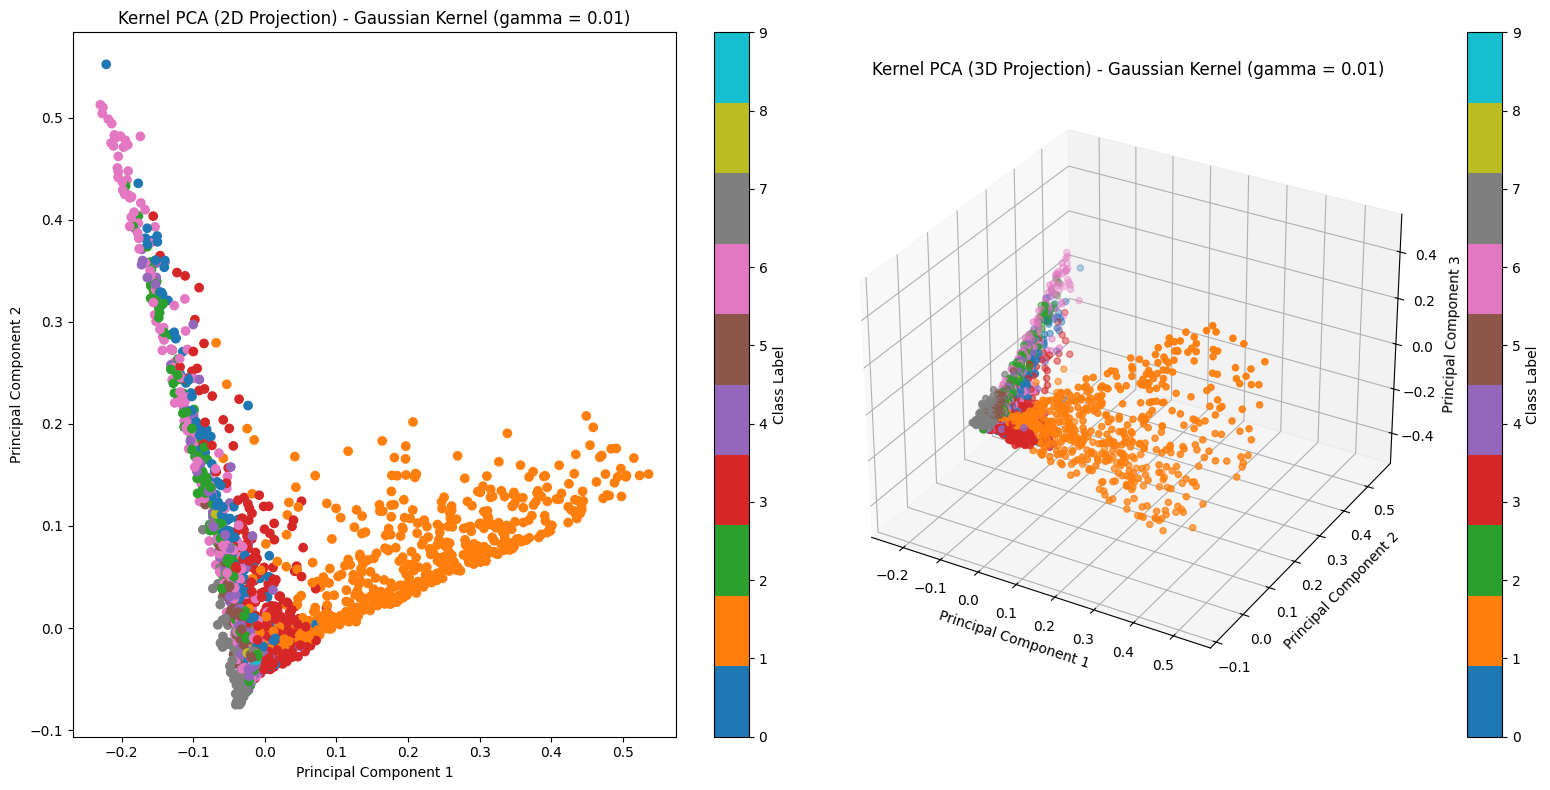

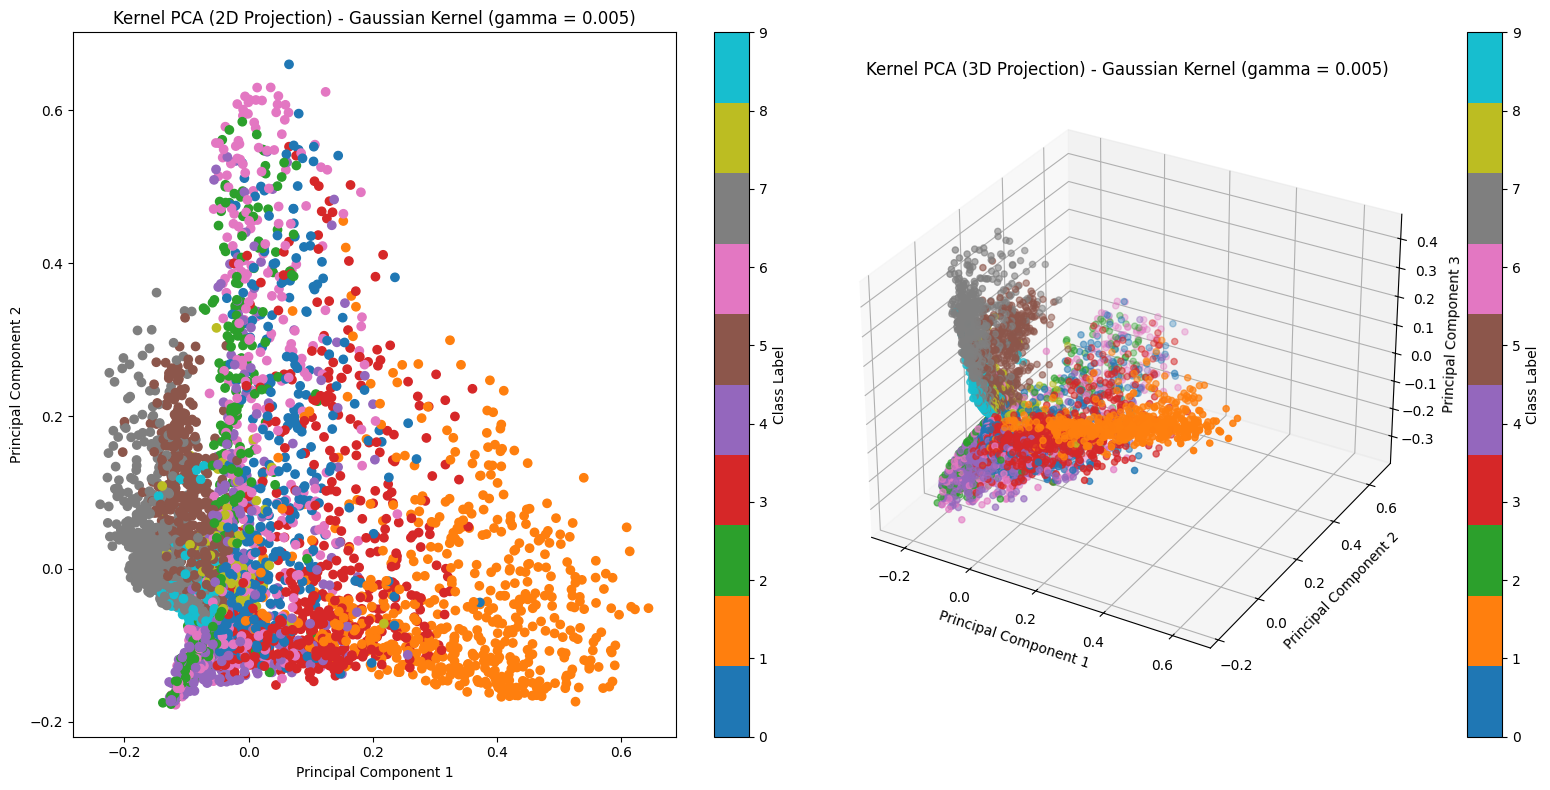

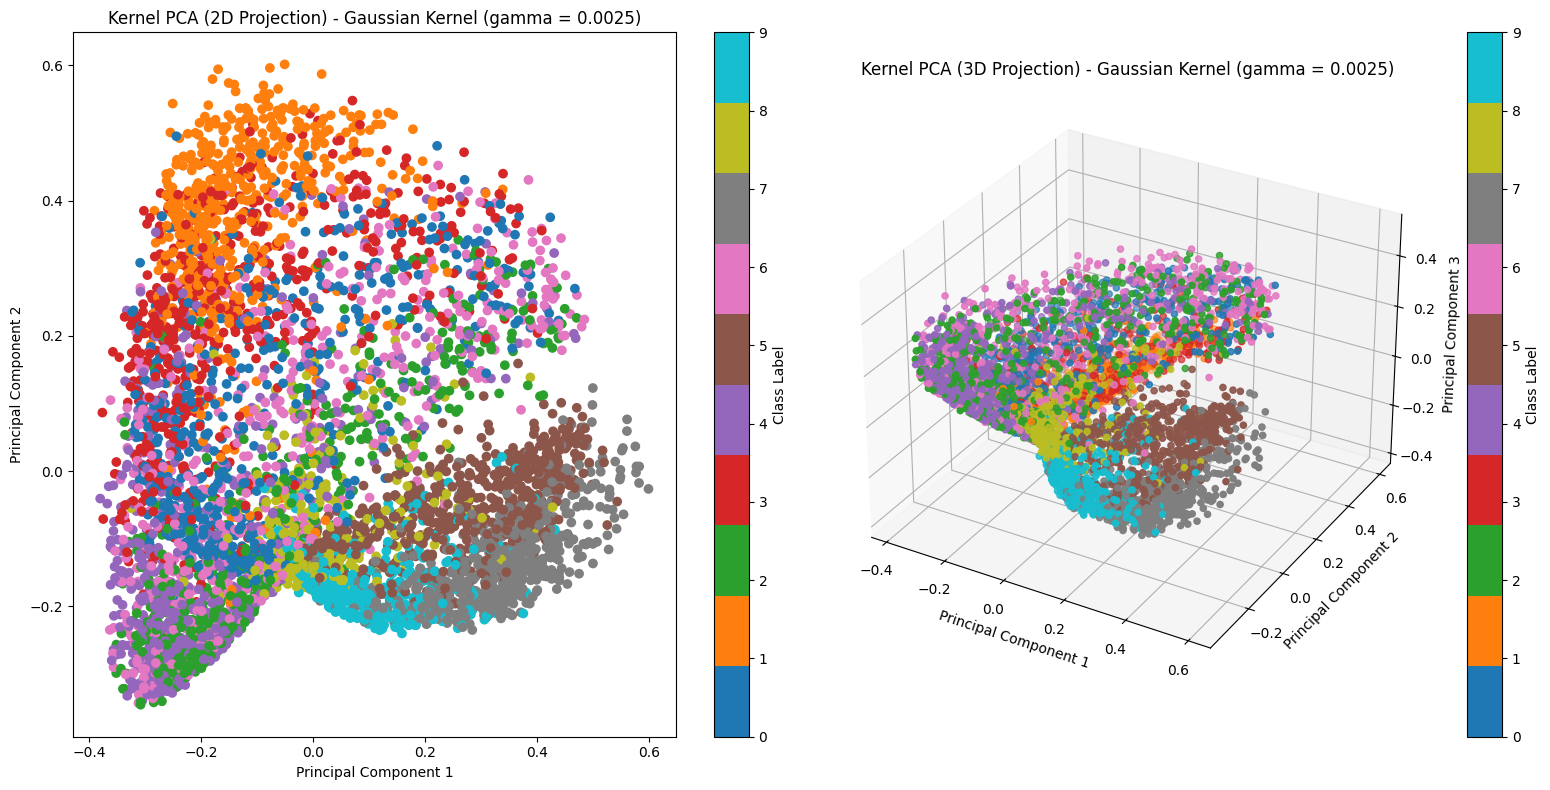

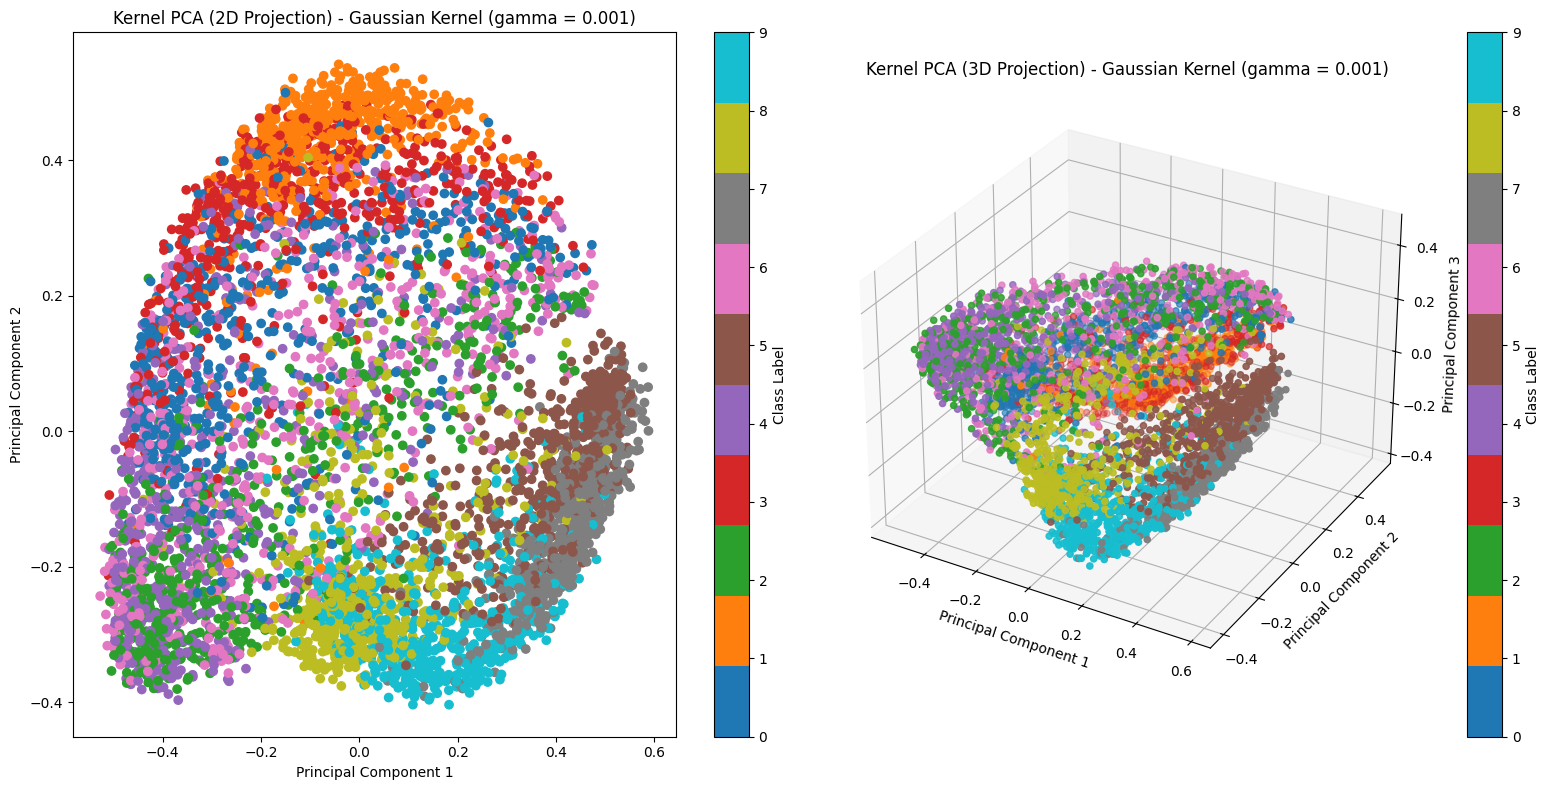

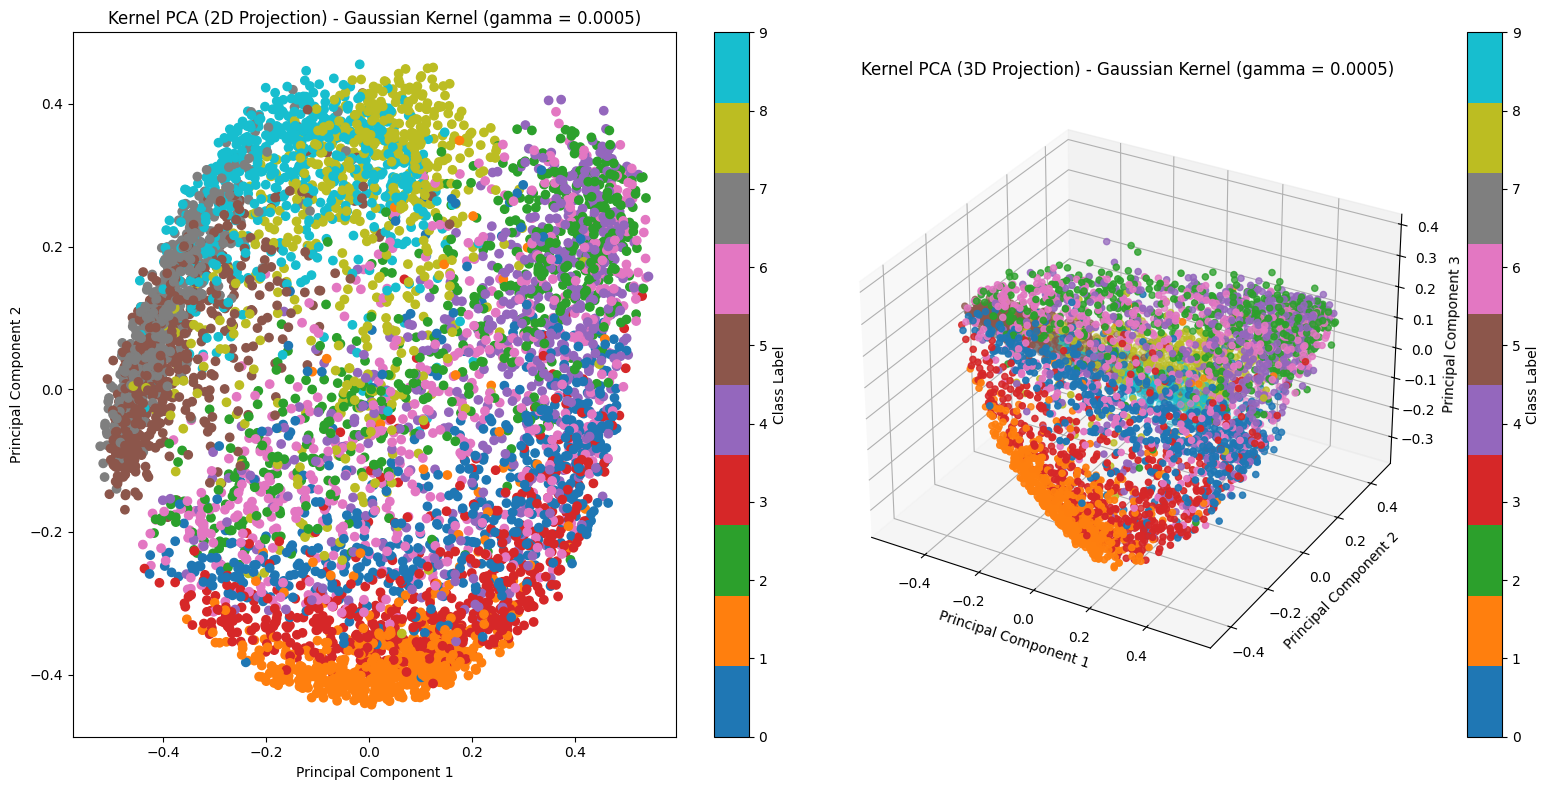

In [40]:
gamma_values = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005]

for gamma in gamma_values:
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=3, kernel='rbf', gamma=gamma)
    principal_components_kpca = kpca.fit_transform(X_train)

    fig = plt.figure(figsize=(16, 8))

    # 2D Plot: First two components
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(principal_components_kpca[:, 0], principal_components_kpca[:, 1], c=y_train, cmap='tab10')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title(f'Kernel PCA (2D Projection) - Gaussian Kernel (gamma = {gamma})')
    plt.colorbar(scatter, ax=ax1, label='Class Label')

    # 3D Plot: First three components
    ax2 = fig.add_subplot(122, projection='3d')
    sc = ax2.scatter(principal_components_kpca[:, 0], principal_components_kpca[:, 1], principal_components_kpca[:, 2],
                     c=y_train, cmap='tab10', depthshade=True)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.set_title(f'Kernel PCA (3D Projection) - Gaussian Kernel (gamma = {gamma})')
    fig.colorbar(sc, ax=ax2, label='Class Label')

    plt.tight_layout()
    plt.show()

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

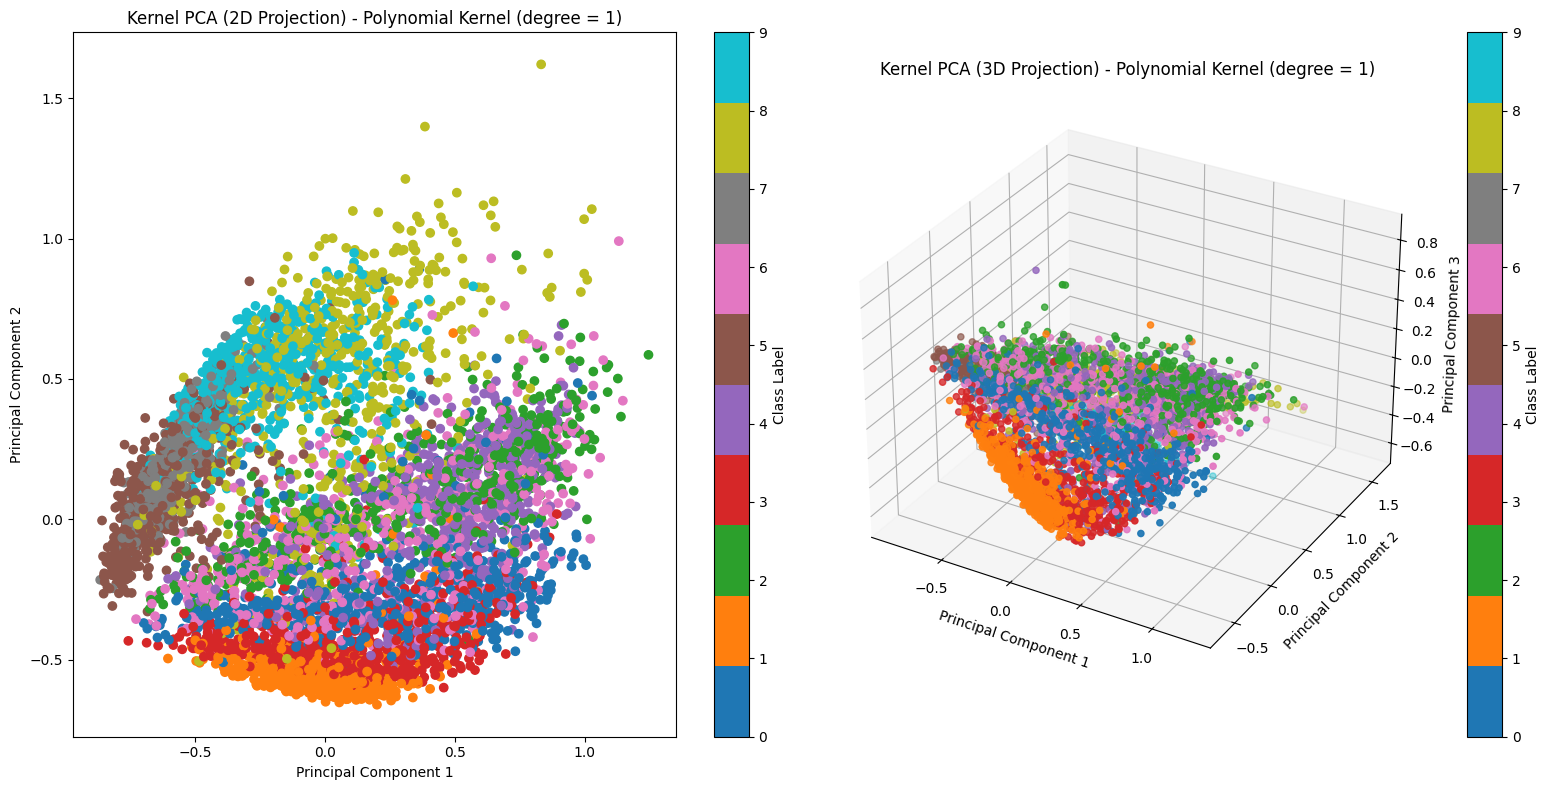

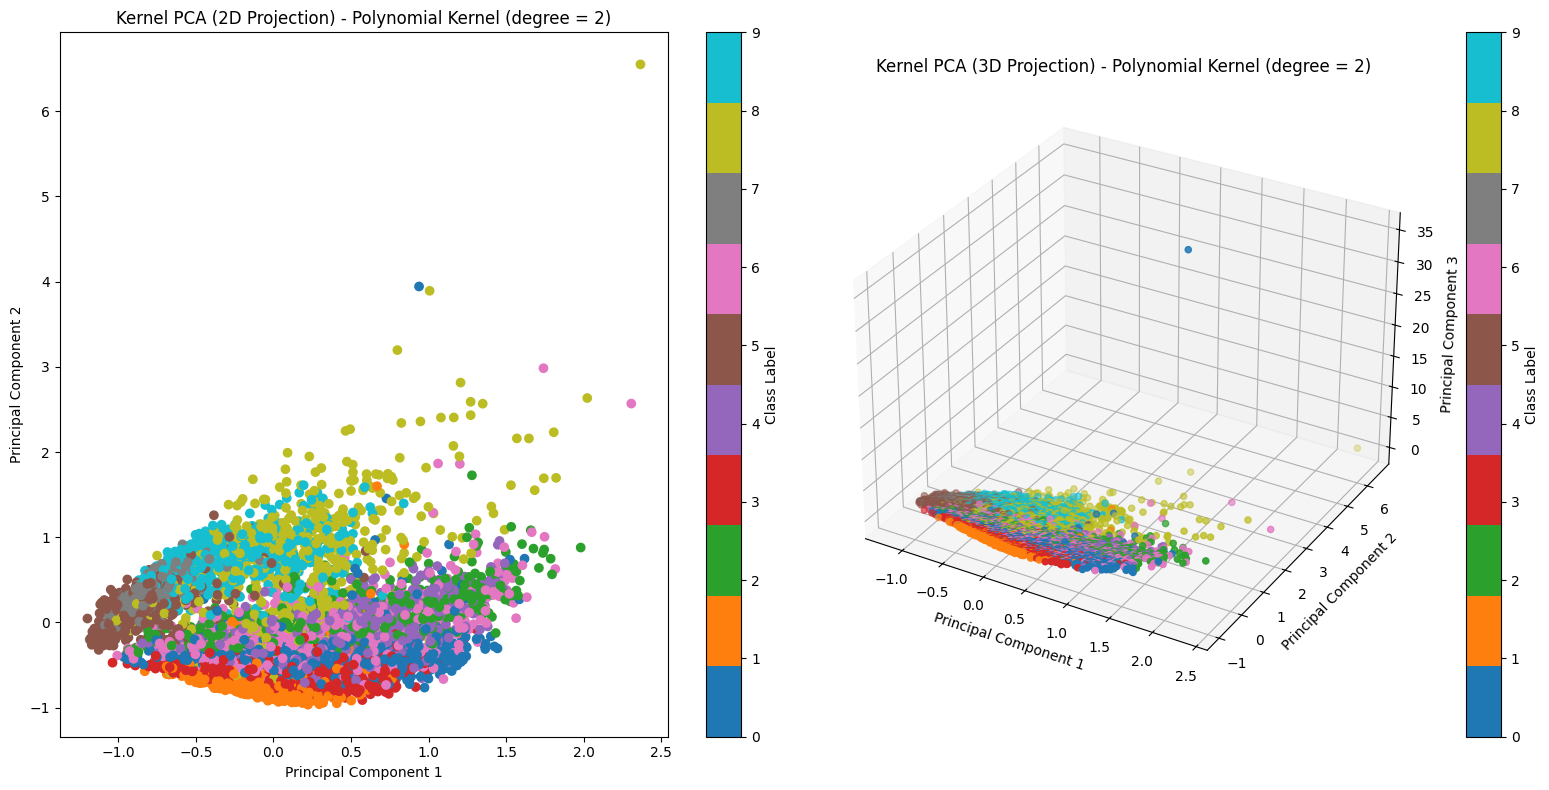

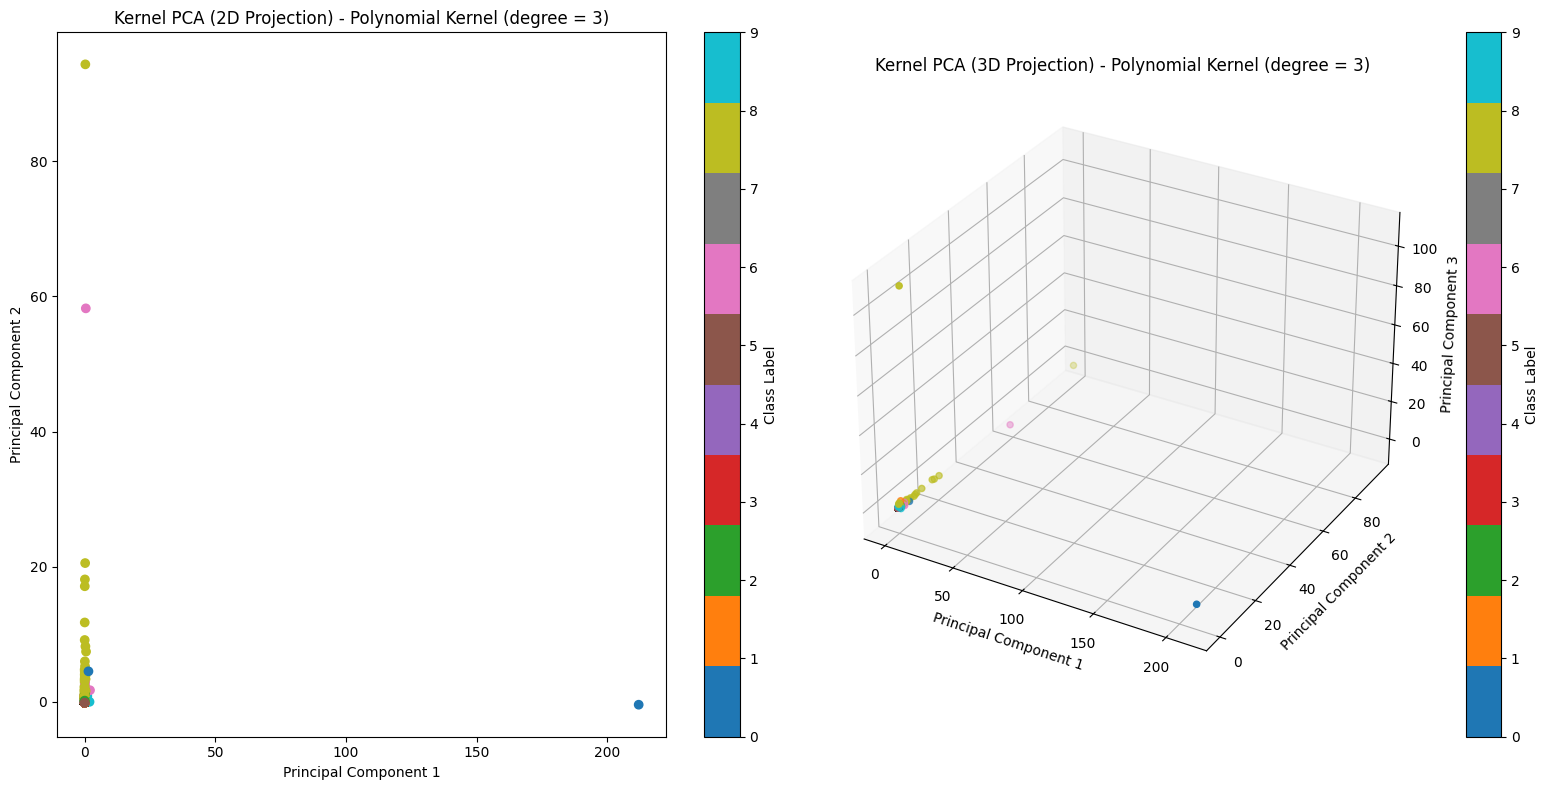

In [41]:
for degree in [1, 2, 3]:
    kpca_poly = KernelPCA(n_components=3, kernel='poly', degree=degree)
    principal_components_poly = kpca_poly.fit_transform(X_train)

    fig = plt.figure(figsize=(16, 8))

    # 2D Plot: First two components
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(principal_components_poly[:, 0], principal_components_poly[:, 1], c=y_train, cmap='tab10')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title(f'Kernel PCA (2D Projection) - Polynomial Kernel (degree = {degree})')
    plt.colorbar(scatter, ax=ax1, label='Class Label')

    # 3D Plot: First three components
    ax2 = fig.add_subplot(122, projection='3d')
    sc = ax2.scatter(principal_components_poly[:, 0], principal_components_poly[:, 1], principal_components_poly[:, 2],
                     c=y_train, cmap='tab10', depthshade=True)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.set_title(f'Kernel PCA (3D Projection) - Polynomial Kernel (degree = {degree})')
    fig.colorbar(sc, ax=ax2, label='Class Label')

    plt.tight_layout()
    plt.show()

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels.

In [42]:
# Explained variance for PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_train)

explained_variance = pca.explained_variance_ratio_
cumsum_explained_variance = np.cumsum(explained_variance)

print(f'Explained Variance: {cumsum_explained_variance[-1]:.2f}')
print(f'Number of components for 75% explained variance: {np.argmax(cumsum_explained_variance > 0.75)}')

Explained Variance: 0.62
Number of components for 75% explained variance: 0


In [43]:
# Explained variance for Kernel PCA - Gaussian Kernel
kpca_gaussian = KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
X_train_kpca_gaussian = kpca_gaussian.fit_transform(X_train)

expvar_ratio_gaussian = kpca_gaussian.eigenvalues_ / kpca_gaussian.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_gaussian)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Number of features for 75% explained variance: 4


In [44]:
# Explained variance for Kernel PCA - Polynomial Kernel
kpca_poly = KernelPCA(n_components=10, kernel='poly', degree=2)
X_train_kpca_poly = kpca_poly.fit_transform(X_train)

expvar_ratio_poly = kpca_poly.eigenvalues_ / kpca_poly.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_poly)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Number of features for 75% explained variance: 5


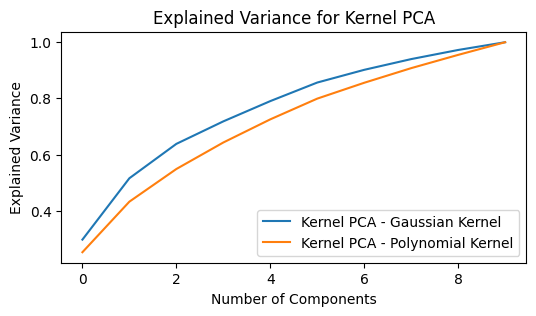

In [45]:
# plot the explained variance for each method
plt.figure(figsize=(6, 3))
plt.plot(np.cumsum(expvar_ratio_gaussian), label='Kernel PCA - Gaussian Kernel')
plt.plot(np.cumsum(expvar_ratio_poly), label='Kernel PCA - Polynomial Kernel')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for Kernel PCA')
plt.legend()
plt.show()

We can see that the best model is the Kernel PCA with Gaussian Kernel

Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable.
    
  

Check if $10$ components reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components:

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio of Kernel PCA')

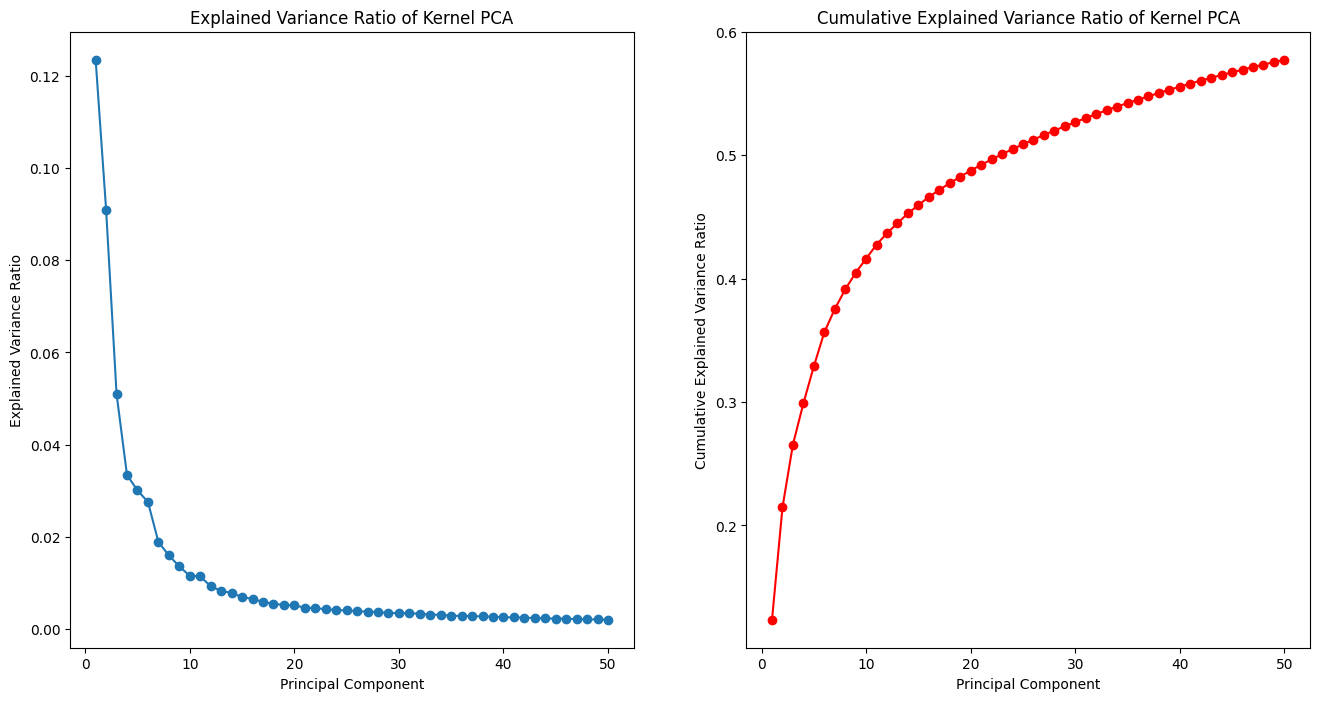

In [46]:
kpca = KernelPCA(kernel='rbf', gamma=0.001)
X_kpca = kpca.fit_transform(X_train)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.plot(range(1, 51), kpca.eigenvalues_[:50]/kpca.eigenvalues_.sum(), 'o-')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio of Kernel PCA')

ax = fig.add_subplot(122)
ax.plot(range(1,51), np.cumsum(kpca.eigenvalues_)[:50]/kpca.eigenvalues_.sum(), 'o-', color='red')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Explained Variance Ratio')
ax.set_title('Cumulative Explained Variance Ratio of Kernel PCA')

Check how well the label-assignment reflect the true labels:

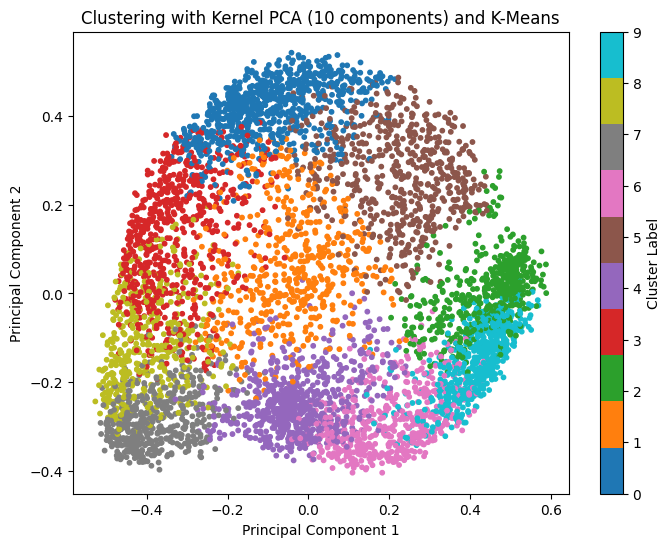

In [47]:
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
X_kpca = kpca.fit_transform(X_train)

# Clustering K-Means on the first 10 principal components with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0)
predicted_labels = kmeans.fit_predict(X_kpca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=predicted_labels, cmap='tab10', s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with Kernel PCA (10 components) and K-Means')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

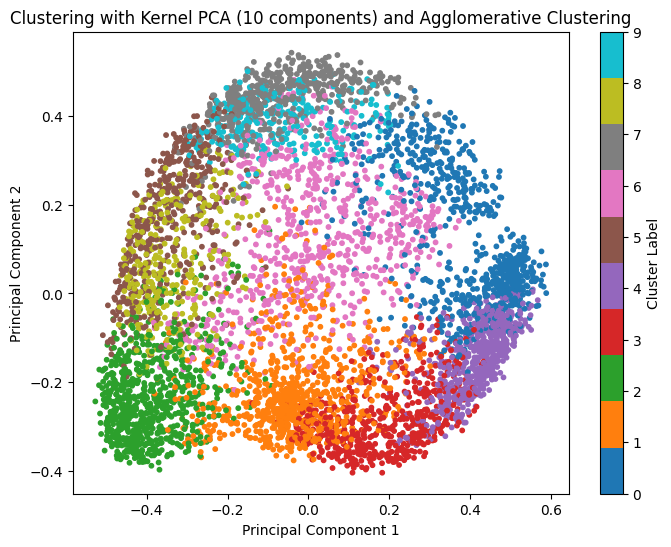

In [48]:
# Perform Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
X_kpca = kpca.fit_transform(X_train)

# Applying Agglomerative Clustering on the transformed data
agg_clustering = AgglomerativeClustering(n_clusters=10)
predicted_labels_agg = agg_clustering.fit_predict(X_kpca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=predicted_labels_agg, cmap='tab10', s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with Kernel PCA (10 components) and Agglomerative Clustering')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

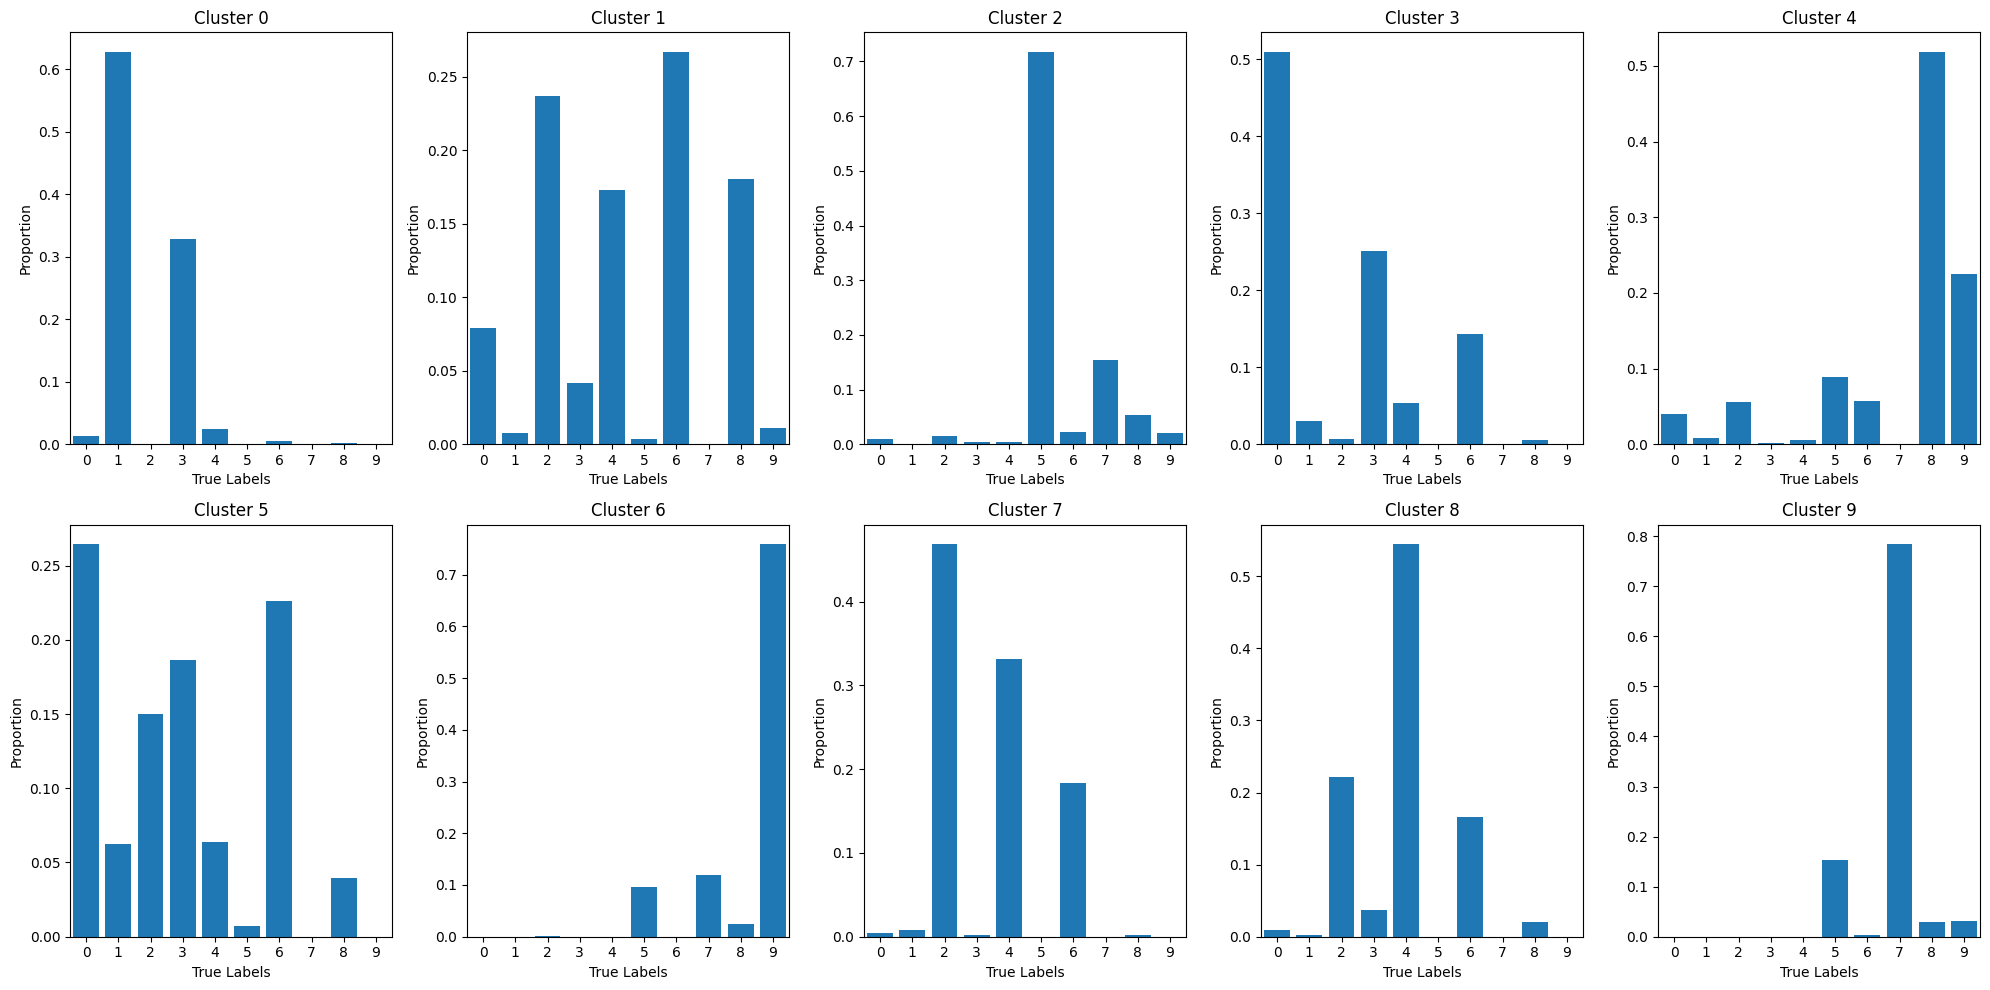

In [49]:
df = pd.DataFrame({'True': y_train, 'Predicted': predicted_labels})

# Calcolo della distribuzione delle etichette in ogni cluster
df['Count'] = 1
df_grouped = df.groupby(['Predicted', 'True']).count().reset_index()
df_grouped = df_grouped.pivot(index='Predicted', columns='True', values='Count').fillna(0)
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
df_grouped.columns = np.arange(10)

fig = plt.figure(figsize=(20, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.bar(df_grouped.columns, df_grouped.loc[i])
    ax.set_xticks(np.arange(10))
    ax.set_xlim(-0.5, 9.5)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('True Labels')
    ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

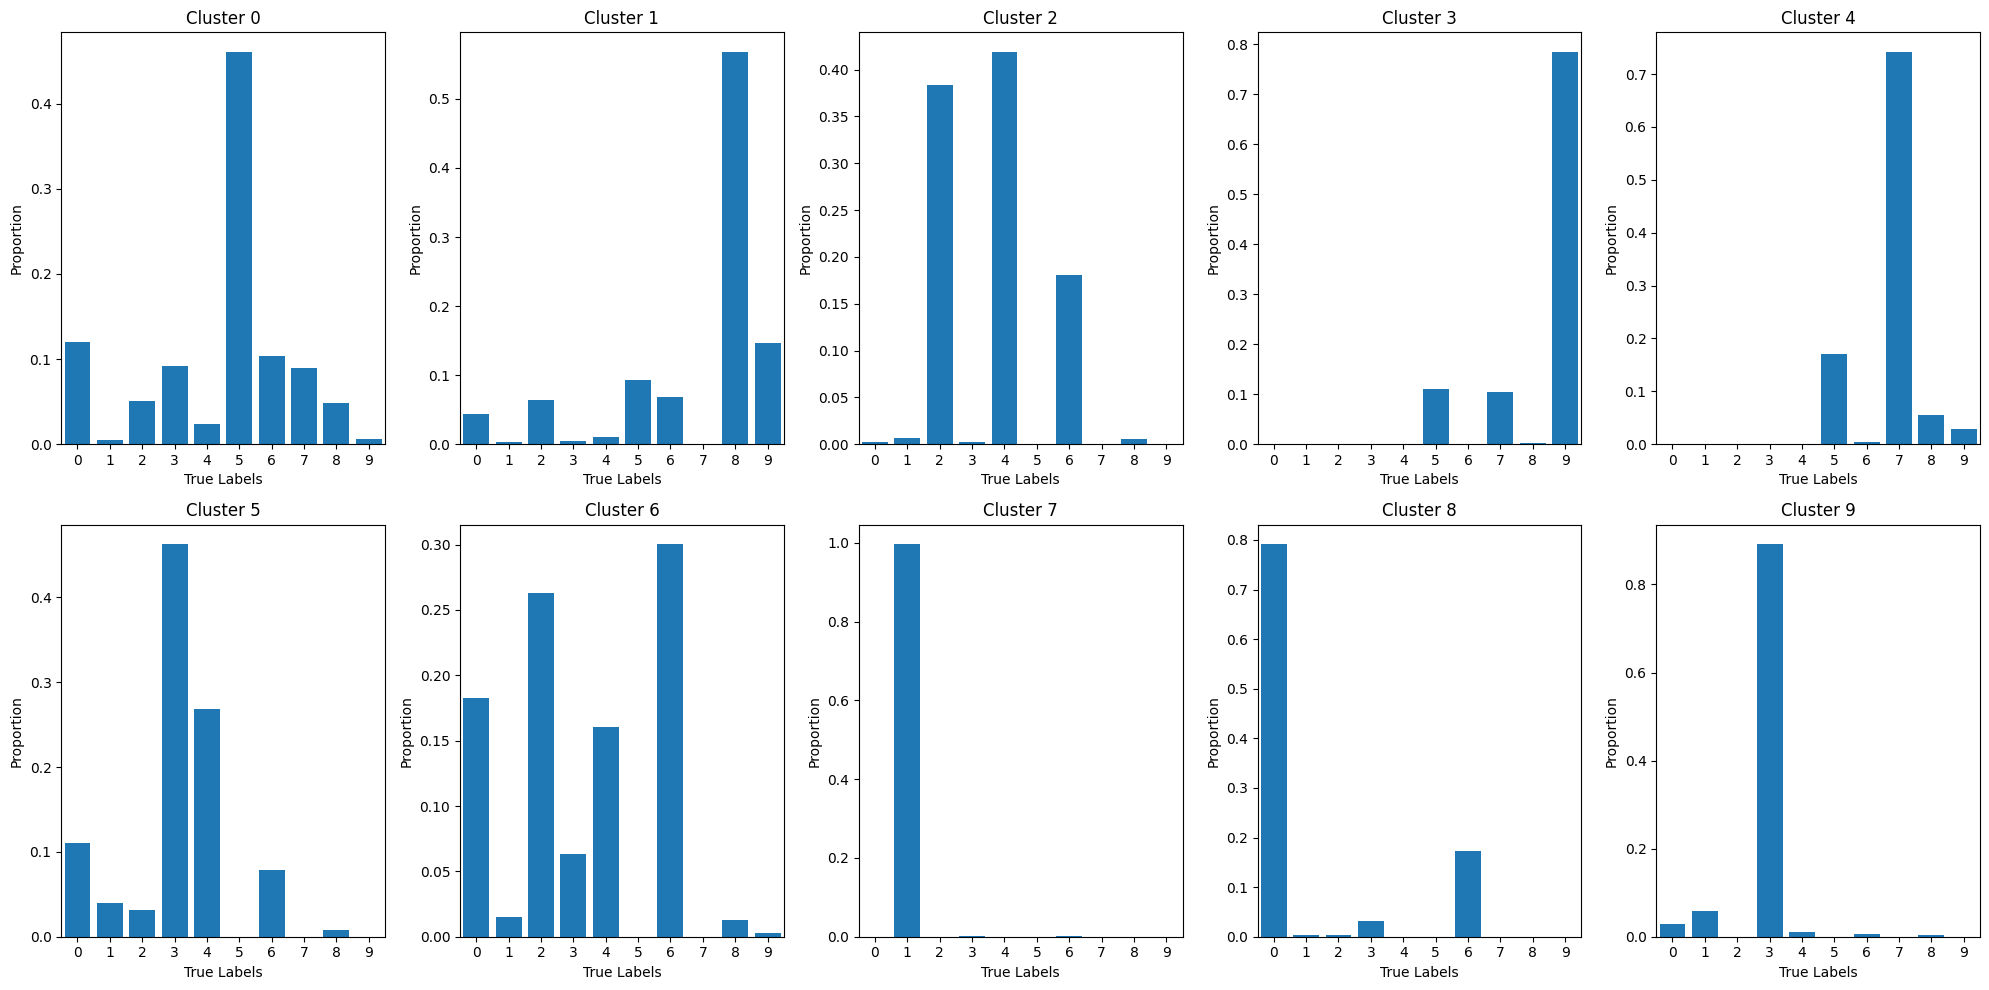

In [50]:
df = pd.DataFrame({'True': y_train, 'Predicted': predicted_labels_agg})

# Calcolo della distribuzione delle etichette in ogni cluster
df['Count'] = 1
df_grouped = df.groupby(['Predicted', 'True']).count().reset_index()
df_grouped = df_grouped.pivot(index='Predicted', columns='True', values='Count').fillna(0)
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
df_grouped.columns = np.arange(10)

fig = plt.figure(figsize=(20, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.bar(df_grouped.columns, df_grouped.loc[i])
    ax.set_xticks(np.arange(10))
    ax.set_xlim(-0.5, 9.5)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('True Labels')
    ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

In [51]:
 kmeans_avg_intracluster_variance, agg_avg_intracluster_variance = 0, 0

for cluster in range(10):
    cluster_labels = y_train[predicted_labels == cluster]
    cluster_variance = np.var(cluster_labels)
    kmeans_avg_intracluster_variance += cluster_variance

    cluster_labels_agg = y_train[predicted_labels_agg == cluster]
    cluster_variance_agg = np.var(cluster_labels_agg)
    agg_avg_intracluster_variance += cluster_variance_agg

kmeans_avg_intracluster_variance /= 10
agg_avg_intracluster_variance /= 10

print(f"Average Intracluster Variance for KMeans: {kmeans_avg_intracluster_variance:.2f}")
print(f"Average Intracluster Variance for Agglomerative Clustering: {agg_avg_intracluster_variance:.2f}")


Average Intracluster Variance for KMeans: 3.25
Average Intracluster Variance for Agglomerative Clustering: 2.85


### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

In [52]:
X_train_svm = X_train
y_train_svm = predicted_labels_agg

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train_svm, y_train_svm, test_size=0.2, random_state=42)

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

In [53]:
def train_svm(X_train, y_train, X_val, y_val, kernel, **kwargs):
    """
    Train and evaluate an SVM model.
    """
    svm = SVC(kernel=kernel, **kwargs)
    svm.fit(X_train, y_train)
    accuracy_train = svm.score(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred)
    return svm, accuracy_train, accuracy_val


def evaluate_kernel(X_train, y_train, X_val, y_val, kernel, param_grid):
    """
    Evaluate an SVM model for a specific kernel and hyperparameter grid.
    """
    best_model = None
    best_accuracy = 0

    for params in param_grid:
        svm, accuracy_train, accuracy_val = train_svm(X_train, y_train, X_val, y_val, kernel, **params)
        param_desc = ", ".join(f"{key}: {value}" for key, value in params.items())
        print(f"Kernel: {kernel}, {param_desc}, Accuracy Train: {accuracy_train:.4f}, Accuracy Val: {accuracy_val:.4f}")

        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
            best_model = svm

    return best_model, best_accuracy


# Define hyperparameter grids
param_grids = {
    'rbf': [{'gamma': gamma} for gamma in [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005]],
    'poly': [{'degree': degree, 'coef0': coef0, 'gamma': 'scale'}
             for degree in [1, 2, 3, 4]
             for coef0 in [0.1, 1, 10]],
    'sigmoid': [{'gamma': gamma, 'coef0': coef0}
                for gamma in [0.01, 0.1, 1, 10]
                for coef0 in [0.1, 1, 10]]
}

# Evaluate all kernels
best_overall_model = None
best_overall_accuracy = 0
best_model_params = None  # To store details of the best model
best_model = None

for kernel, param_grid in param_grids.items():
    print(f"\nEvaluating Kernel: {kernel}")
    model, best_accuracy = evaluate_kernel(X_train_svm, y_train_svm, X_val_svm, y_val_svm, kernel, param_grid)

    if best_accuracy > best_overall_accuracy:
        best_model = model
        best_overall_accuracy = best_accuracy
        best_overall_model = best_model
        best_model_params = {"kernel": kernel, **param_grid[param_grid.index({'gamma': best_model._gamma})]}  # Store params

# Print the best model details
print(f"\nBest Model Overall Accuracy: {best_overall_accuracy:.4f}")
print(f"Best Model Parameters: Kernel = {best_model_params['kernel']}, "
      f"Params = {', '.join([f'{k}: {v}' for k, v in best_model_params.items() if k != 'kernel'])}")


Evaluating Kernel: rbf
Kernel: rbf, gamma: 0.1, Accuracy Train: 1.0000, Accuracy Val: 0.1567
Kernel: rbf, gamma: 0.05, Accuracy Train: 1.0000, Accuracy Val: 0.1767
Kernel: rbf, gamma: 0.025, Accuracy Train: 1.0000, Accuracy Val: 0.3575
Kernel: rbf, gamma: 0.01, Accuracy Train: 0.9998, Accuracy Val: 0.7808
Kernel: rbf, gamma: 0.005, Accuracy Train: 0.9981, Accuracy Val: 0.9200
Kernel: rbf, gamma: 0.0025, Accuracy Train: 0.9925, Accuracy Val: 0.9467
Kernel: rbf, gamma: 0.001, Accuracy Train: 0.9765, Accuracy Val: 0.9442
Kernel: rbf, gamma: 0.0005, Accuracy Train: 0.9598, Accuracy Val: 0.9367

Evaluating Kernel: poly
Kernel: poly, degree: 1, coef0: 0.1, gamma: scale, Accuracy Train: 0.9529, Accuracy Val: 0.9275
Kernel: poly, degree: 1, coef0: 1, gamma: scale, Accuracy Train: 0.9529, Accuracy Val: 0.9275
Kernel: poly, degree: 1, coef0: 10, gamma: scale, Accuracy Train: 0.9529, Accuracy Val: 0.9275
Kernel: poly, degree: 2, coef0: 0.1, gamma: scale, Accuracy Train: 0.9738, Accuracy Val: 0.9

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

In [54]:
# Model definition
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_hidden_layers=2, output_size=10):
        super(FullyConnectedNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.model(x))


# Training function
def train_model(
    model,
    train_loader,
    eval_loader,
    epochs=100,
    learning_rate=1e-3,
    device="cpu",
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        train_loss, train_accuracy = _train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Evaluation phase
        val_loss, val_accuracy = _evaluate_model(model, eval_loader, criterion, device)
        val_losses.append(val_loss)

        # Logging
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

    return model, train_accuracy, val_accuracy, train_losses, val_losses


def _train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(data_loader), accuracy

def _evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(data_loader), accuracy


Training FCNN 1
Epoch 1/50, Train Loss: 1.7748, Train Acc: 0.7373, Val Loss: 1.6423, Val Acc: 0.8275
Epoch 2/50, Train Loss: 1.6425, Train Acc: 0.8250, Val Loss: 1.6318, Val Acc: 0.8300
Epoch 3/50, Train Loss: 1.6248, Train Acc: 0.8394, Val Loss: 1.6184, Val Acc: 0.8467
Epoch 4/50, Train Loss: 1.5773, Train Acc: 0.8873, Val Loss: 1.5752, Val Acc: 0.8892
Epoch 5/50, Train Loss: 1.5547, Train Acc: 0.9102, Val Loss: 1.5703, Val Acc: 0.8917
Epoch 6/50, Train Loss: 1.5483, Train Acc: 0.9165, Val Loss: 1.5754, Val Acc: 0.8875
Epoch 7/50, Train Loss: 1.5481, Train Acc: 0.9144, Val Loss: 1.5652, Val Acc: 0.8958
Epoch 8/50, Train Loss: 1.5458, Train Acc: 0.9177, Val Loss: 1.5681, Val Acc: 0.8942
Epoch 9/50, Train Loss: 1.5417, Train Acc: 0.9206, Val Loss: 1.5716, Val Acc: 0.8908
Epoch 10/50, Train Loss: 1.5373, Train Acc: 0.9258, Val Loss: 1.5719, Val Acc: 0.8908
Epoch 11/50, Train Loss: 1.5385, Train Acc: 0.9237, Val Loss: 1.5732, Val Acc: 0.8908
Epoch 12/50, Train Loss: 1.5342, Train Acc: 0.

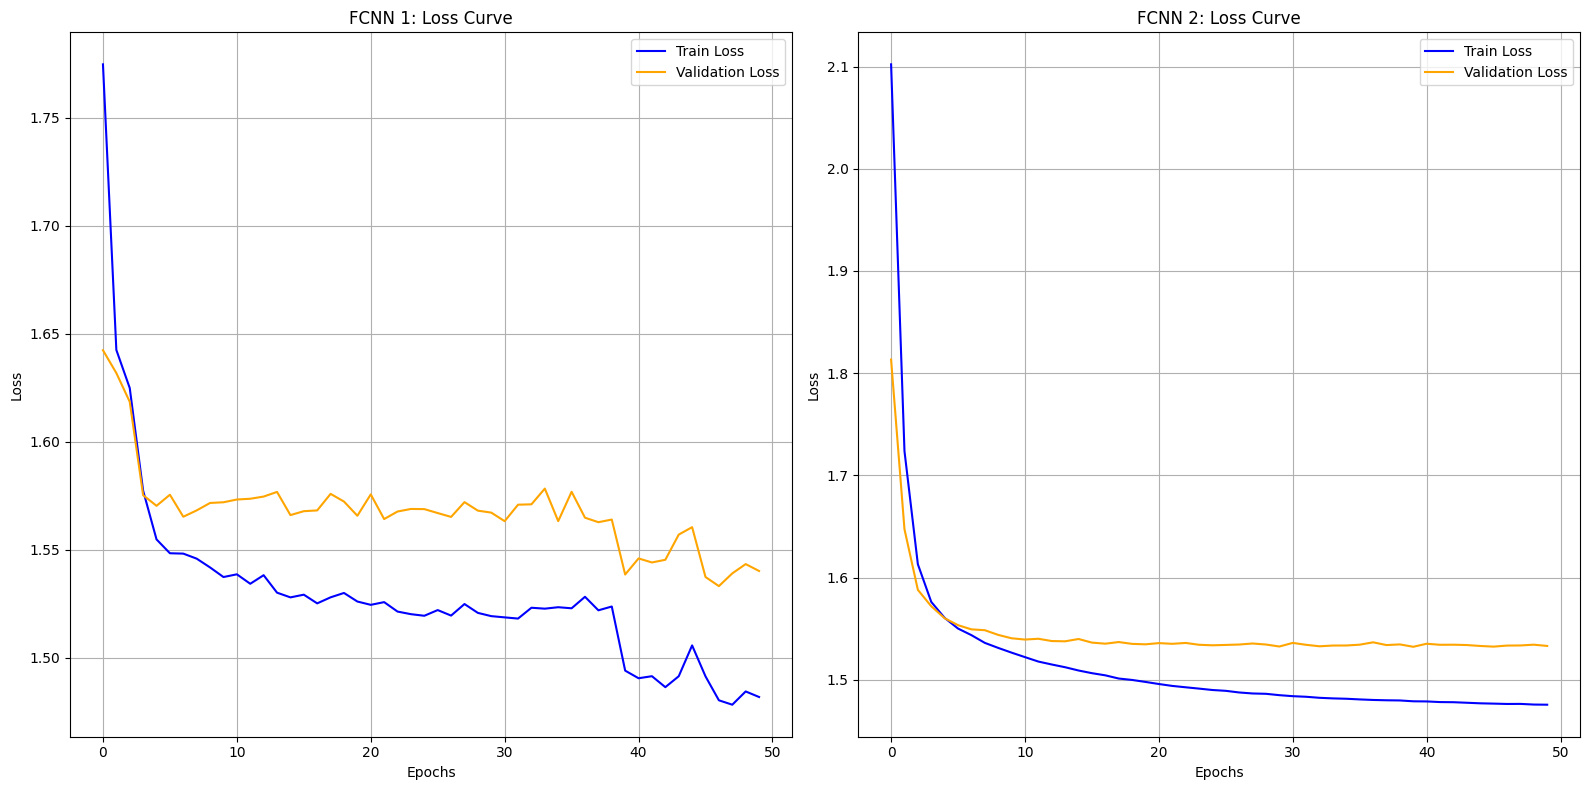

In [55]:
X_train_nn = torch.tensor(np.array(X_train_svm)).float()
y_train_nn = torch.tensor(np.array(y_train_svm)).long()
X_val_nn = torch.tensor(np.array(X_val_svm)).float()
y_val_nn = torch.tensor(np.array(y_val_svm)).long()

train_dataset = TensorDataset(X_train_nn, y_train_nn)
val_dataset = TensorDataset(X_val_nn, y_val_nn)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64

nn_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
nn_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modelli definiti con FullyConnectedNN
nn1 = FullyConnectedNN(hidden_size=128, num_hidden_layers=2).to(DEVICE)
nn2 = FullyConnectedNN(hidden_size=256, num_hidden_layers=2).to(DEVICE)

# Addestramento e valutazione del primo modello
print("\nTraining FCNN 1")
nn1, train_accuracy_1, val_accuracy_1, train_losses_1, val_losses_1 = train_model(
    nn1, nn_train_loader, nn_val_loader, epochs=50, learning_rate=1e-3, device=DEVICE
)

# Addestramento e valutazione del secondo modello
print("\nTraining FCNN 2")
nn2, train_accuracy_2, val_accuracy_2, train_losses_2, val_losses_2 = train_model(
    nn2, nn_train_loader, nn_val_loader, epochs=50, learning_rate=1e-4, device=DEVICE
)

fig = plt.figure(figsize=(16, 8))

# FCNN 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_losses_1, label='Train Loss', color='blue')
ax1.plot(val_losses_1, label='Validation Loss', color='orange')
ax1.set_title('FCNN 1: Loss Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# FCNN 2
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_losses_2, label='Train Loss', color='blue')
ax2.plot(val_losses_2, label='Validation Loss', color='orange')
ax2.set_title('FCNN 2: Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.


Training CNN
Epoch 1/100, Train Loss: 1.7623, Train Acc: 0.7092, Val Loss: 1.6791, Val Acc: 0.7825
Epoch 2/100, Train Loss: 1.6747, Train Acc: 0.7871, Val Loss: 1.6717, Val Acc: 0.7908
Epoch 3/100, Train Loss: 1.6753, Train Acc: 0.7840, Val Loss: 1.6843, Val Acc: 0.7750
Epoch 4/100, Train Loss: 1.6677, Train Acc: 0.7931, Val Loss: 1.6613, Val Acc: 0.8000
Epoch 5/100, Train Loss: 1.6599, Train Acc: 0.8004, Val Loss: 1.6502, Val Acc: 0.8117
Epoch 6/100, Train Loss: 1.6312, Train Acc: 0.8292, Val Loss: 1.6323, Val Acc: 0.8267
Epoch 7/100, Train Loss: 1.6179, Train Acc: 0.8440, Val Loss: 1.6349, Val Acc: 0.8267
Epoch 8/100, Train Loss: 1.6149, Train Acc: 0.8454, Val Loss: 1.6258, Val Acc: 0.8358
Epoch 9/100, Train Loss: 1.6052, Train Acc: 0.8556, Val Loss: 1.6095, Val Acc: 0.8517
Epoch 10/100, Train Loss: 1.6075, Train Acc: 0.8531, Val Loss: 1.6389, Val Acc: 0.8200
Epoch 11/100, Train Loss: 1.5979, Train Acc: 0.8648, Val Loss: 1.6174, Val Acc: 0.8408
Epoch 12/100, Train Loss: 1.5962, Trai

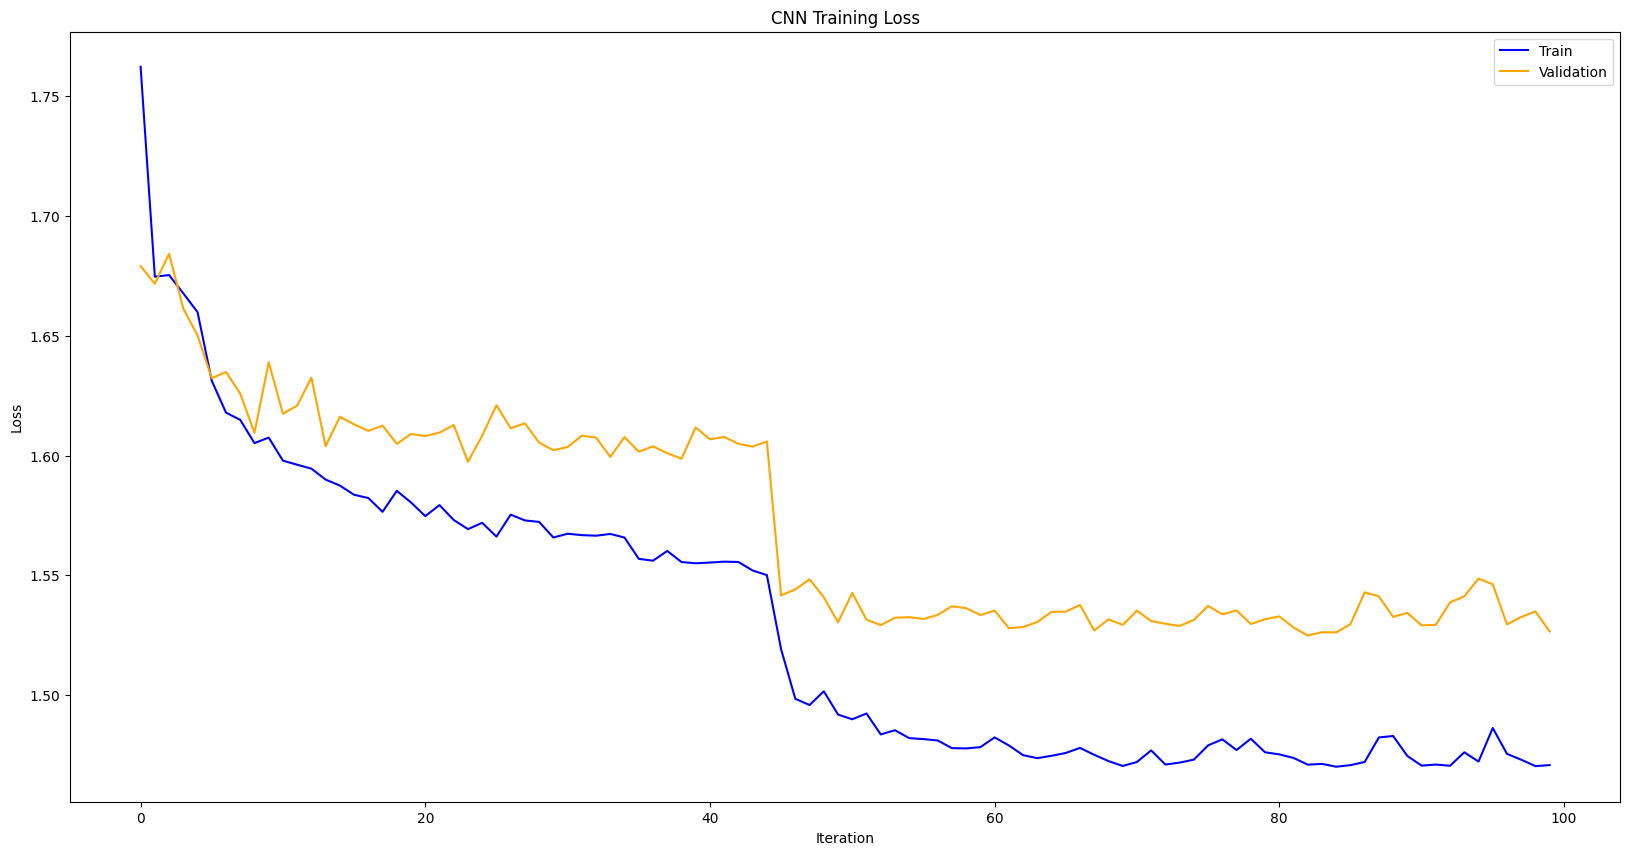

In [56]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Ridimensionamento input
        x = x.view(-1, 1, 28, 28)
        x = self.conv_block(x)  # Passaggio attraverso il blocco convoluzionale
        x = self.fc_block(x)  # Passaggio attraverso il blocco fully connected
        return self.softmax(x)

EPOCHS = 100
LEARNING_RATE = 1e-3

cnn = CNN().to(DEVICE)

# Addestramento del modello
print("\nTraining CNN")
cnn, train_acc_cnn, val_acc_cnn, train_loss_cnn, val_loss_cnn = train_model(
    cnn, nn_train_loader, nn_val_loader, EPOCHS, LEARNING_RATE, DEVICE
)

print("\n\nFinal accuracies on validation set")
print(f"CNN: {val_acc_cnn}")

plt.figure(figsize=(20, 10))
plt.plot(train_loss_cnn, label="Train", color="blue")
plt.plot(val_loss_cnn, label="Validation", color="orange")
plt.title("CNN Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

In [59]:
# Map the number-like labels (original labels) to numeric indices
class_assignments = {label: i for i, label in enumerate(df_grouped.columns)}

# Transform the number-like labels to numeric indices
cluster_labels = np.array([class_assignments[label] for label in df_grouped.idxmax(axis=1).values])

# Function to predict and map
def predict_and_map(model, X_test):
    if isinstance(model, torch.nn.Module):
        X_test = torch.tensor(X_test).float().to(DEVICE)
        model.eval()
        with torch.no_grad():
            output = model(X_test)
            _, predicted = torch.max(output.data, 1)
            predicted = predicted.cpu().numpy()
    else:
        predicted = model.predict(X_test)

    # Map cluster predictions to numeric indices
    return cluster_labels[predicted]

# Predict using the models and calculate accuracy
svm_predicted = predict_and_map(best_model, X_test)
nn1_predicted = predict_and_map(nn1, X_test)
nn2_predicted = predict_and_map(nn2, X_test)
cnn_predicted = predict_and_map(cnn, X_test)

# Calculate accuracies
svm_accuracy = accuracy_score(svm_predicted, y_test)
nn1_accuracy = accuracy_score(nn1_predicted, y_test)
nn2_accuracy = accuracy_score(nn2_predicted, y_test)
cnn_accuracy = accuracy_score(cnn_predicted, y_test)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"FCNN 1 Accuracy: {nn1_accuracy:.4f}")
print(f"FCNN 2 Accuracy: {nn2_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")

SVM Accuracy: 0.5995
FCNN 1 Accuracy: 0.5830
FCNN 2 Accuracy: 0.5986
CNN Accuracy: 0.6051


In [61]:
from sklearn.metrics import classification_report

In [65]:
# Print classification reports for each model
print("Classification Report for SVM:")
print(classification_report(y_test, svm_predicted))

print("\nClassification Report for FCNN 1:")
print(classification_report(y_test, nn1_predicted))

print("\nClassification Report for FCNN 2:")
print(classification_report(y_test, nn2_predicted))

print("\nClassification Report for CNN:")
print(classification_report(y_test, cnn_predicted))

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.82      0.49      0.61      1000
           1       1.00      0.88      0.93      1000
           2       0.00      0.00      0.00      1000
           3       0.61      0.73      0.67      1000
           4       0.43      0.56      0.48      1000
           5       0.46      0.59      0.52      1000
           6       0.29      0.35      0.32      1000
           7       0.77      0.79      0.78      1000
           8       0.56      0.86      0.67      1000
           9       0.79      0.75      0.77      1000

    accuracy                           0.60     10000
   macro avg       0.57      0.60      0.58     10000
weighted avg       0.57      0.60      0.58     10000


Classification Report for FCNN 1:
              precision    recall  f1-score   support

           0       0.82      0.47      0.60      1000
           1       0.99      0.87      0.93      1000
           2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [63]:
X_train_svm = X_train
y_train_svm = y_train

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train_svm, y_train_svm, test_size=0.2, random_state=42)

- **Kernel SVM**

In [66]:
# Evaluate all kernels
best_overall_model = None
best_overall_accuracy = 0
best_model_params = None

for kernel, param_grid in param_grids.items():
    print(f"\nEvaluating Kernel: {kernel}")
    model, best_accuracy = evaluate_kernel(X_train_svm, y_train_svm, X_val_svm, y_val_svm, kernel, param_grid)

    if best_accuracy > best_overall_accuracy:
        best_model = model
        best_overall_accuracy = best_accuracy
        best_overall_model = best_model

        # Get the actual parameters of the best model
        best_model_actual_params = best_model.get_params()

        # Find the corresponding param set in param_grid
        best_model_params = {"kernel": kernel}
        for params in param_grid:
            if all(best_model_actual_params.get(key) == value for key, value in params.items()):
                best_model_params.update(params)
                break

# Print the best model details
print(f"\nBest Model Overall Accuracy: {best_overall_accuracy:.4f}")
print(f"Best Model Parameters: Kernel = {best_model_params['kernel']}, "
      f"Params = {', '.join([f'{k}: {v}' for k, v in best_model_params.items() if k != 'kernel'])}")


Evaluating Kernel: rbf
Kernel: rbf, gamma: 0.1, Accuracy Train: 1.0000, Accuracy Val: 0.1008
Kernel: rbf, gamma: 0.05, Accuracy Train: 1.0000, Accuracy Val: 0.1792
Kernel: rbf, gamma: 0.025, Accuracy Train: 1.0000, Accuracy Val: 0.4725
Kernel: rbf, gamma: 0.01, Accuracy Train: 0.9965, Accuracy Val: 0.7042
Kernel: rbf, gamma: 0.005, Accuracy Train: 0.9827, Accuracy Val: 0.8033
Kernel: rbf, gamma: 0.0025, Accuracy Train: 0.9479, Accuracy Val: 0.8400
Kernel: rbf, gamma: 0.001, Accuracy Train: 0.8998, Accuracy Val: 0.8458
Kernel: rbf, gamma: 0.0005, Accuracy Train: 0.8642, Accuracy Val: 0.8417

Evaluating Kernel: poly
Kernel: poly, degree: 1, coef0: 0.1, gamma: scale, Accuracy Train: 0.8712, Accuracy Val: 0.8467
Kernel: poly, degree: 1, coef0: 1, gamma: scale, Accuracy Train: 0.8712, Accuracy Val: 0.8467
Kernel: poly, degree: 1, coef0: 10, gamma: scale, Accuracy Train: 0.8712, Accuracy Val: 0.8467
Kernel: poly, degree: 2, coef0: 0.1, gamma: scale, Accuracy Train: 0.9025, Accuracy Val: 0.8

- **FCNN**

In [67]:
# Model definition
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_hidden_layers=2, output_size=10):
        super(FullyConnectedNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.model(x))


# Training function
def train_model(
    model,
    train_loader,
    eval_loader,
    epochs=100,
    learning_rate=1e-3,
    device="cpu",
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        train_loss, train_accuracy = _train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Evaluation phase
        val_loss, val_accuracy = _evaluate_model(model, eval_loader, criterion, device)
        val_losses.append(val_loss)

        # Logging
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

    return model, train_accuracy, val_accuracy, train_losses, val_losses


def _train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(data_loader), accuracy


def _evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(data_loader), accuracy


Training FCNN 1
Epoch 1/50, Train Loss: 1.8391, Train Acc: 0.6731, Val Loss: 1.7051, Val Acc: 0.7650
Epoch 2/50, Train Loss: 1.6813, Train Acc: 0.7871, Val Loss: 1.6675, Val Acc: 0.7967
Epoch 3/50, Train Loss: 1.6466, Train Acc: 0.8221, Val Loss: 1.6419, Val Acc: 0.8225
Epoch 4/50, Train Loss: 1.6248, Train Acc: 0.8402, Val Loss: 1.6421, Val Acc: 0.8250
Epoch 5/50, Train Loss: 1.6098, Train Acc: 0.8565, Val Loss: 1.6385, Val Acc: 0.8217
Epoch 6/50, Train Loss: 1.6049, Train Acc: 0.8602, Val Loss: 1.6279, Val Acc: 0.8375
Epoch 7/50, Train Loss: 1.5917, Train Acc: 0.8746, Val Loss: 1.6278, Val Acc: 0.8342
Epoch 8/50, Train Loss: 1.5891, Train Acc: 0.8752, Val Loss: 1.6367, Val Acc: 0.8250
Epoch 9/50, Train Loss: 1.5812, Train Acc: 0.8802, Val Loss: 1.6289, Val Acc: 0.8325
Epoch 10/50, Train Loss: 1.5804, Train Acc: 0.8821, Val Loss: 1.6197, Val Acc: 0.8392
Epoch 11/50, Train Loss: 1.5730, Train Acc: 0.8915, Val Loss: 1.6292, Val Acc: 0.8350
Epoch 12/50, Train Loss: 1.5677, Train Acc: 0.

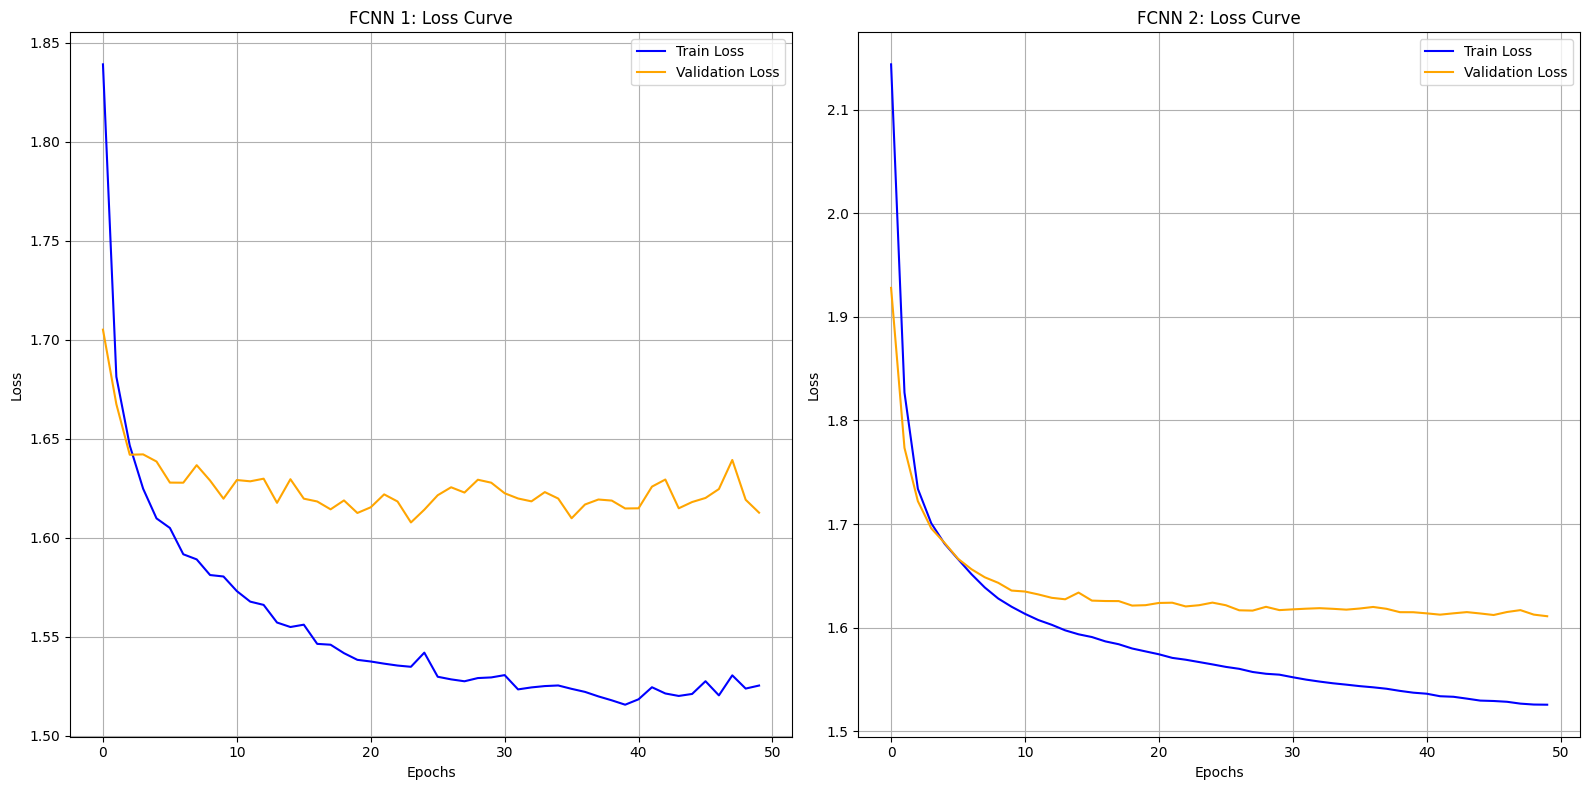

In [68]:
X_train_nn = torch.tensor(np.array(X_train_svm)).float()
y_train_nn = torch.tensor(np.array(y_train_svm)).long()
X_val_nn = torch.tensor(np.array(X_val_svm)).float()
y_val_nn = torch.tensor(np.array(y_val_svm)).long()

train_dataset = TensorDataset(X_train_nn, y_train_nn)
val_dataset = TensorDataset(X_val_nn, y_val_nn)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64

nn_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
nn_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

nn1 = FullyConnectedNN(hidden_size=128, num_hidden_layers=2).to(DEVICE)
nn2 = FullyConnectedNN(hidden_size=256, num_hidden_layers=2).to(DEVICE)

print("\nTraining FCNN 1")
nn1, train_accuracy_1, val_accuracy_1, train_losses_1, val_losses_1 = train_model(
    nn1, nn_train_loader, nn_val_loader, epochs=50, learning_rate=1e-3, device=DEVICE
)

print("\nTraining FCNN 2")
nn2, train_accuracy_2, val_accuracy_2, train_losses_2, val_losses_2 = train_model(
    nn2, nn_train_loader, nn_val_loader, epochs=50, learning_rate=1e-4, device=DEVICE
)

fig = plt.figure(figsize=(16, 8))

# FCNN 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_losses_1, label='Train Loss', color='blue')
ax1.plot(val_losses_1, label='Validation Loss', color='orange')
ax1.set_title('FCNN 1: Loss Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# FCNN 2
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_losses_2, label='Train Loss', color='blue')
ax2.plot(val_losses_2, label='Validation Loss', color='orange')
ax2.set_title('FCNN 2: Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

- **CNN**


Training CNN
Epoch 1/100, Train Loss: 1.8783, Train Acc: 0.5921, Val Loss: 1.7830, Val Acc: 0.6808
Epoch 2/100, Train Loss: 1.7633, Train Acc: 0.6994, Val Loss: 1.7606, Val Acc: 0.7000
Epoch 3/100, Train Loss: 1.7335, Train Acc: 0.7285, Val Loss: 1.6918, Val Acc: 0.7717
Epoch 4/100, Train Loss: 1.6665, Train Acc: 0.7969, Val Loss: 1.6658, Val Acc: 0.7958
Epoch 5/100, Train Loss: 1.6507, Train Acc: 0.8119, Val Loss: 1.6612, Val Acc: 0.8042
Epoch 6/100, Train Loss: 1.6309, Train Acc: 0.8313, Val Loss: 1.6504, Val Acc: 0.8150
Epoch 7/100, Train Loss: 1.6114, Train Acc: 0.8521, Val Loss: 1.6266, Val Acc: 0.8383
Epoch 8/100, Train Loss: 1.5975, Train Acc: 0.8656, Val Loss: 1.6283, Val Acc: 0.8358
Epoch 9/100, Train Loss: 1.5901, Train Acc: 0.8731, Val Loss: 1.6139, Val Acc: 0.8483
Epoch 10/100, Train Loss: 1.5830, Train Acc: 0.8806, Val Loss: 1.6211, Val Acc: 0.8392
Epoch 11/100, Train Loss: 1.5779, Train Acc: 0.8842, Val Loss: 1.6059, Val Acc: 0.8558
Epoch 12/100, Train Loss: 1.5725, Trai

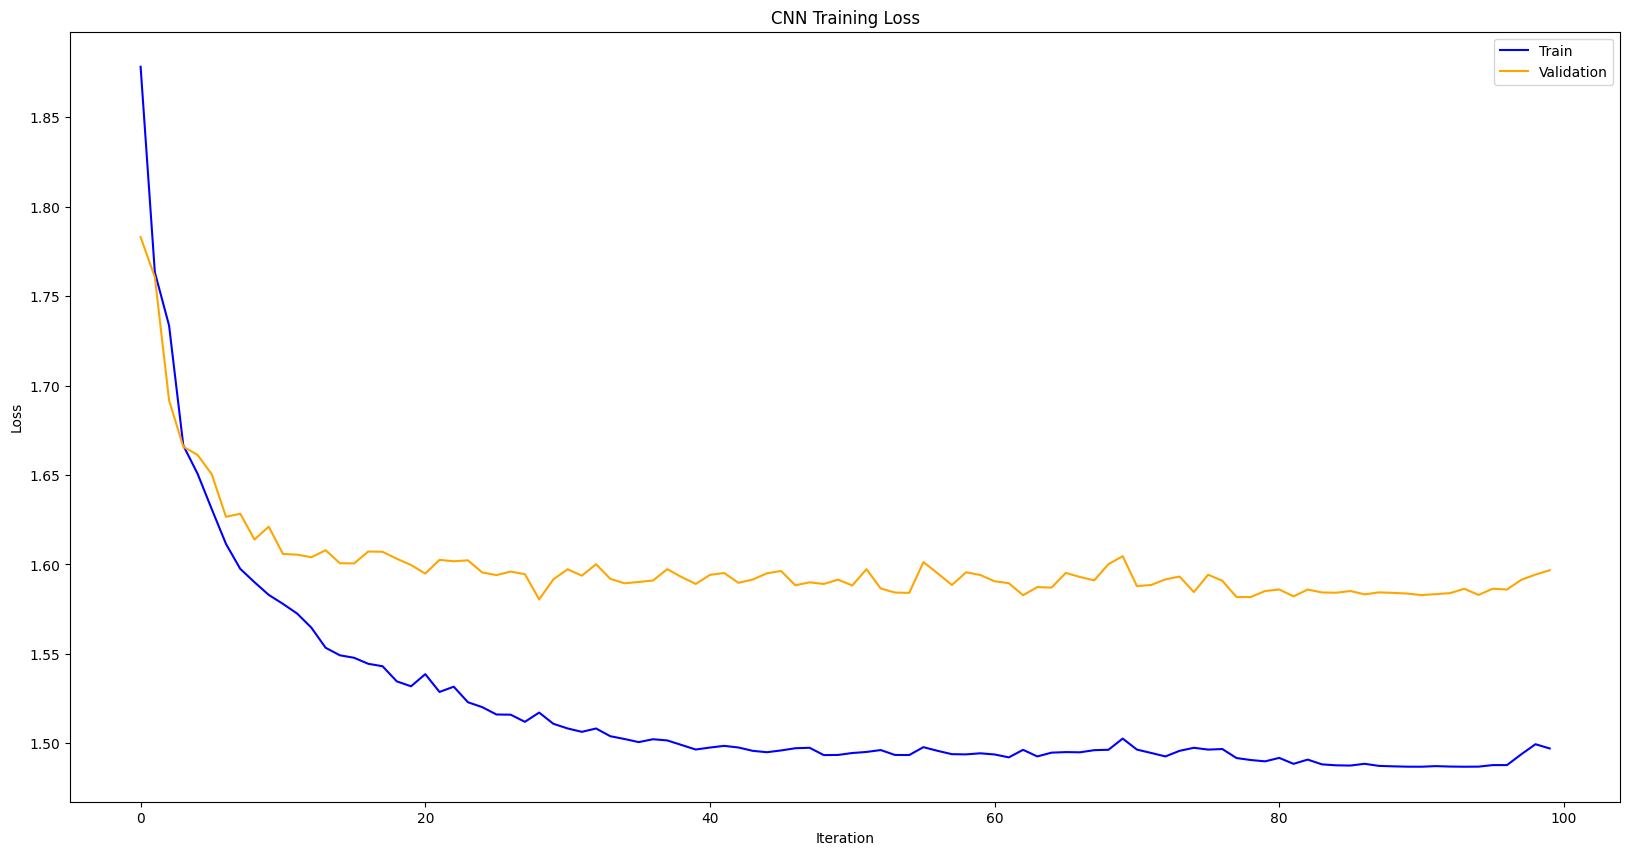

In [69]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_block(x)  # Passaggio attraverso il blocco convoluzionale
        x = self.fc_block(x)  # Passaggio attraverso il blocco fully connected
        return self.softmax(x)

EPOCHS = 100
LEARNING_RATE = 1e-3

cnn = CNN().to(DEVICE)

print("\nTraining CNN")
cnn, train_acc_cnn, val_acc_cnn, train_loss_cnn, val_loss_cnn = train_model(
    cnn, nn_train_loader, nn_val_loader, EPOCHS, LEARNING_RATE, DEVICE
)

print("\n\nFinal accuracies on validation set")
print(f"CNN: {val_acc_cnn}")

plt.figure(figsize=(20, 10))
plt.plot(train_loss_cnn, label="Train", color="blue")
plt.plot(val_loss_cnn, label="Validation", color="orange")
plt.title("CNN Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using the best SVM kernel model
y_val_svm_pred = best_overall_model.predict(X_val_svm)

# Accuracy and classification report for SVM
accuracy_svm = accuracy_score(y_val_svm, y_val_svm_pred)
report_svm = classification_report(y_val_svm, y_val_svm_pred)

print("\nSVM Accuracy:", accuracy_svm)
print("\nSVM Classification Report:\n", report_svm)


SVM Accuracy: 0.8516666666666667

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       115
           1       0.98      0.96      0.97       115
           2       0.76      0.74      0.75       133
           3       0.88      0.91      0.89       106
           4       0.79      0.80      0.80       126
           5       0.96      0.87      0.92       119
           6       0.68      0.65      0.66       123
           7       0.89      0.93      0.91       116
           8       0.95      0.92      0.93       120
           9       0.89      0.93      0.91       127

    accuracy                           0.85      1200
   macro avg       0.86      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



In [72]:
# Predict using FCNN1
nn1.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    y_val_nn1_pred = nn1(X_val_nn.to(DEVICE)).argmax(dim=1).cpu().numpy()

# Predict using FCNN2
nn2.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    y_val_nn2_pred = nn2(X_val_nn.to(DEVICE)).argmax(dim=1).cpu().numpy()

# Accuracy and classification report for FCNN1
accuracy_nn1 = accuracy_score(y_val_nn, y_val_nn1_pred)
report_nn1 = classification_report(y_val_nn, y_val_nn1_pred)

# Accuracy and classification report for FCNN2
accuracy_nn2 = accuracy_score(y_val_nn, y_val_nn2_pred)
report_nn2 = classification_report(y_val_nn, y_val_nn2_pred)

print("\nFCNN1 Accuracy:", accuracy_nn1)
print("\nFCNN1 Classification Report:\n", report_nn1)

print("\nFCNN2 Accuracy:", accuracy_nn2)
print("\nFCNN2 Classification Report:\n", report_nn2)



FCNN1 Accuracy: 0.8475

FCNN1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.80       115
           1       0.97      0.96      0.96       115
           2       0.82      0.77      0.79       133
           3       0.86      0.92      0.89       106
           4       0.78      0.81      0.79       126
           5       0.97      0.86      0.91       119
           6       0.68      0.59      0.63       123
           7       0.85      0.91      0.88       116
           8       0.95      0.93      0.94       120
           9       0.87      0.92      0.90       127

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200


FCNN2 Accuracy: 0.8525

FCNN2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       115
           1       0.9

In [73]:
# Predict using CNN
cnn.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    y_val_cnn_pred = cnn(X_val_nn.to(DEVICE)).argmax(dim=1).cpu().numpy()

# Accuracy and classification report for CNN
accuracy_cnn = accuracy_score(y_val_nn, y_val_cnn_pred)
report_cnn = classification_report(y_val_nn, y_val_cnn_pred)

print("\nCNN Accuracy:", accuracy_cnn)
print("\nCNN Classification Report:\n", report_cnn)


CNN Accuracy: 0.8658333333333333

CNN Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       115
           1       0.97      0.98      0.97       115
           2       0.87      0.71      0.79       133
           3       0.82      0.92      0.86       106
           4       0.84      0.87      0.85       126
           5       1.00      0.87      0.93       119
           6       0.65      0.72      0.69       123
           7       0.85      0.95      0.89       116
           8       0.97      0.93      0.95       120
           9       0.92      0.94      0.93       127

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200

